In [ ]:
!pip install xlsxwriter
!pip install torch-geometric
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.1 MB/s eta 0:00:00


In [ ]:
#Step1: Cutting the data (Not using it)

import numpy as np
import pandas as pd

# Read the Excel file
df = pd.read_excel("/content/sumana(1)_wl1.xlsx", sheet_name="Sheet2")

# Skip the first 24 rows
df = df.iloc[23:]

list1 = []
window_size = 360
overlap_size = 240

# Iterate through the DataFrame with overlapping windows
for i in range(0, len(df), window_size):
    # Get a window with the next 360 rows
    window = df[i:i + window_size]

    # Append the window to the list
    list1.append(window)

    # Get the next 240 rows
    overlap = df[i + window_size:i + window_size + overlap_size]

    # Append the overlap to the list
    list1.append(overlap)

# Save each window and overlap in a new sheet
with pd.ExcelWriter("output.xlsx") as writer:
    for i, data_frame in enumerate(list1):
        data_frame.to_excel(writer, sheet_name=f"Sheet_{i+1}", index=False)


In [ ]:
#Step1: Cutting the data

import pandas as pd
import numpy as np

k=pd.read_excel('/content/sumana_wl1.xlsx', sheet_name= 'Sheet2')

list_360=[]
list_240=[]
for i in range(23,len(k),600):
        j=k[i:i+360]
        m=k[i+360:i+360+240]
        list_360.append(j)
        list_240.append(m)

with pd.ExcelWriter('output_wl1.xlsx') as writer:
   for i in range(len(list_360)):
       m=pd.DataFrame(list_360[i])
       k=m.iloc[:,0:14]
       k.to_excel(writer,sheet_name=f"Q{i+1}", index=False)

'''with pd.ExcelWriter('240.xlsx') as writer:
   for i in range(len(list_240)):
       m=pd.DataFrame(list_240[i])
       k=m.iloc[:,0:14]
       k.to_excel(writer,sheet_name=str(i+1))'''

"with pd.ExcelWriter('240.xlsx') as writer:\n   for i in range(len(list_240)):\n       m=pd.DataFrame(list_240[i])\n       k=m.iloc[:,0:14]\n       k.to_excel(writer,sheet_name=str(i+1))"

In [ ]:
#Step2: Finding deoxygenated and oxygenated normalisation


import pandas as pd
import os

# Read the Excel file into a dictionary of DataFrames, with sheet names as keys
input_file_path = '/content/output_wl1.xlsx'  # Replace with your actual file path
output_file_path = 'normalized_output_wl1.xlsx'  # Replace with your desired output file path

# Load all sheets into a dictionary
xls = pd.ExcelFile(input_file_path)
all_sheets = {sheet_name: xls.parse(sheet_name) for sheet_name in xls.sheet_names}

# Initialize a dictionary to store normalized DataFrames
normalized_sheets = {}

# Loop through each sheet
for sheet_name, df in all_sheets.items():
    # Calculate min and max for each column in the current sheet
    column_mins = df.min()
    column_maxs = df.max()

    # Normalize each column using the provided equation
    normalized_df = (df - column_mins) / (column_maxs - column_mins)

    # Store the normalized DataFrame in the dictionary
    normalized_sheets[sheet_name] = normalized_df

    print(f"Normalized data for {sheet_name} stored in the dictionary.")

# Save the normalized DataFrames to a new Excel file with different sheets
with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
    for sheet_name, normalized_df in normalized_sheets.items():
        normalized_df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Normalized data saved to {output_file_path}")




Normalized data for Q1 stored in the dictionary.
Normalized data for Q2 stored in the dictionary.
Normalized data for Q3 stored in the dictionary.
Normalized data for Q4 stored in the dictionary.
Normalized data for Q5 stored in the dictionary.
Normalized data for Q6 stored in the dictionary.
Normalized data for Q7 stored in the dictionary.
Normalized data for Q8 stored in the dictionary.
Normalized data for Q9 stored in the dictionary.
Normalized data for Q10 stored in the dictionary.
Normalized data for Q11 stored in the dictionary.
Normalized data saved to normalized_output_wl1.xlsx


In [ ]:
#Step3: Find the difference


import pandas as pd

# Read the Excel files
xls1 = pd.ExcelFile("/content/normalized_output_wl1.xlsx")
xls2 = pd.ExcelFile("/content/normalized_output_wl2.xlsx")

# Get all sheet names from both Excel files
all_sheet_names = set(xls1.sheet_names + xls2.sheet_names)

# Create a dictionary to store DataFrames for each sheet's subtraction result
result_sheets = {}

# Iterate through sheet names in the order they appear in xls1.sheet_names
for sheet_name in xls1.sheet_names:
    # Check if the sheet name exists in both Excel files
    if sheet_name in xls2.sheet_names:
        # Read DataFrames from both Excel files for the current sheet
        df_sheet1 = xls1.parse(sheet_name)
        df_sheet2 = xls2.parse(sheet_name)

        # Check if both DataFrames have the same shape
        if df_sheet1.shape == df_sheet2.shape:
            # Subtract the values of the matrix in Sheet2 from the matrix in Sheet1
            result_matrix = df_sheet1.values - df_sheet2.values

            # Create a new DataFrame with the result matrix
            df_result = pd.DataFrame(result_matrix, columns=df_sheet1.columns, index=df_sheet1.index)

            # Store the result DataFrame in the dictionary
            result_sheets[sheet_name] = df_result
        else:
            print(f"Skipping sheet '{sheet_name}' because matrices have different shapes.")

# Save the result DataFrames to a new Excel file with different sheets
output_file_path = "/content/o2_file.xlsx"
with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
    for sheet_name in xls1.sheet_names:
        if sheet_name in result_sheets:
            df_result = result_sheets[sheet_name]
            df_result.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Difference data saved to {output_file_path}")


Difference data saved to /content/o2_file.xlsx


In [ ]:
#Step4: Filter


import pandas as pd
import numpy as np
from scipy.signal import ellip, filtfilt

# Function to apply an elliptical bandpass filter to a matrix
def elliptical_bandpass_filter(matrix, lowcut, highcut, fs, rp, rs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # Design an elliptic bandpass filter
    b, a = ellip(order, rp, rs, [low, high], btype='band')

    # Apply the elliptical bandpass filter to each row of the matrix
    filtered_matrix = np.array([filtfilt(b, a, row, padlen=0) for row in matrix])

    return filtered_matrix

# Read the input Excel file
input_file_path = "/content/o2_file.xlsx"
xls_input = pd.ExcelFile(input_file_path)

# Create a dictionary to store DataFrames for each filtered sheet
filtered_sheets = {}

# Iterate through all sheet names
for sheet_name in xls_input.sheet_names:
    # Read the DataFrame from the input Excel file
    df_input = xls_input.parse(sheet_name)

    # Apply the elliptical bandpass filter to the matrix in the current sheet
    filtered_matrix = elliptical_bandpass_filter(
        df_input.values, lowcut=0.01, highcut=2, fs=6, rp=1, rs=60, order=4
    )

    # Create a new DataFrame with the filtered matrix
    df_filtered = pd.DataFrame(filtered_matrix, columns=df_input.columns, index=df_input.index)

    # Store the result DataFrame in the dictionary
    filtered_sheets[sheet_name] = df_filtered

# Save the filtered DataFrames to a new Excel file with different sheets
output_file_path = "/content/output_filtered_elliptical.xlsx"
with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
    for sheet_name, df_filtered in filtered_sheets.items():
        df_filtered.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Filtered data saved to {output_file_path}")



Filtered data saved to /content/output_filtered_elliptical.xlsx


In [ ]:
#Step5: Correlation


import pandas as pd

# Read the input Excel file with multiple sheets
input_file_path = "/content/Neutral_filtered_merged_50.xlsx"
xls_input = pd.ExcelFile(input_file_path)

# Create an empty Excel writer to save the correlation matrices
output_correlation_path = "/content/Neutral_correlation_merged.xlsx"
with pd.ExcelWriter(output_correlation_path, engine='xlsxwriter') as writer:

    # Iterate through all sheet names
    for sheet_name in xls_input.sheet_names:
        # Read the DataFrame from the input Excel file
        df_input = xls_input.parse(sheet_name)

        # Create an empty matrix to store correlations
        num_columns = len(df_input.columns)
        correlation_matrix = pd.DataFrame(index=range(num_columns), columns=range(num_columns))

        # Calculate Pearson's correlation between each pair of columns
        for i in range(num_columns):
            for j in range(num_columns):
                correlation_matrix.iloc[i, j] = df_input.iloc[:, i].corr(df_input.iloc[:, j])

        # Save the correlation matrix as a separate sheet in the new Excel file
        correlation_matrix.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"All correlation matrices saved to {output_correlation_path}")



All correlation matrices saved to /content/Neutral_correlation_merged.xlsx


In [ ]:
import pandas as pd
import numpy as np

# Define input and output file paths
input_file_path = "/content/Afraid_correlation_merged.xlsx"
output_file_path = "Afraid_degree_matrix.xlsx"

# Create an empty Excel writer to save the degree matrices
with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:

    # Read each Excel file
    xls_input = pd.ExcelFile(input_file_path)

    # Iterate through all sheet names in all Excel files
    for sheet_name in xls_input.sheet_names:
        # Read the DataFrame from the input Excel file, skipping the first row
        correlation_matrix = pd.read_excel(input_file_path, sheet_name=sheet_name, index_col=None, header=0)

        # Set the first column as index
        correlation_matrix.set_index(correlation_matrix.columns[0], inplace=True)

        # Calculate the degree for each variable
        degrees = np.abs(correlation_matrix).sum(axis=1)

        # Construct the diagonal matrix
        degree_matrix = np.diag(degrees)

        # Convert the degree matrix to a DataFrame for saving
        degree_df = pd.DataFrame(degree_matrix, index=correlation_matrix.index, columns=correlation_matrix.index)

        # Save the degree matrix as a separate sheet in the new Excel file
        degree_df.to_excel(writer, sheet_name=sheet_name, index=False, index_label=False)

print(f"All degree matrices saved to {output_file_path}")


All degree matrices saved to Afraid_degree_matrix.xlsx


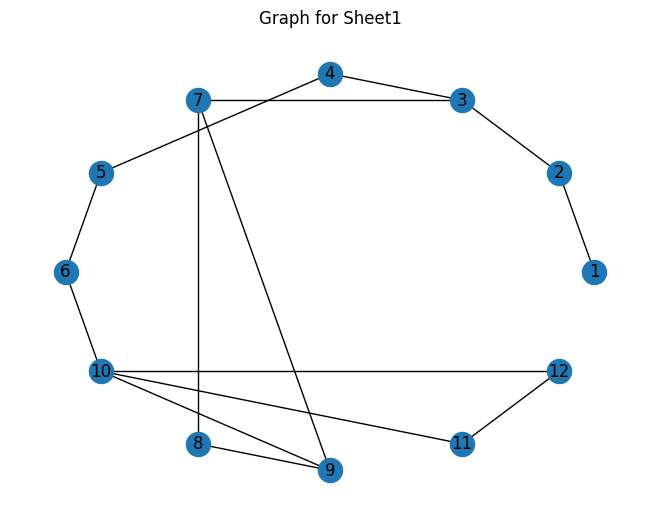

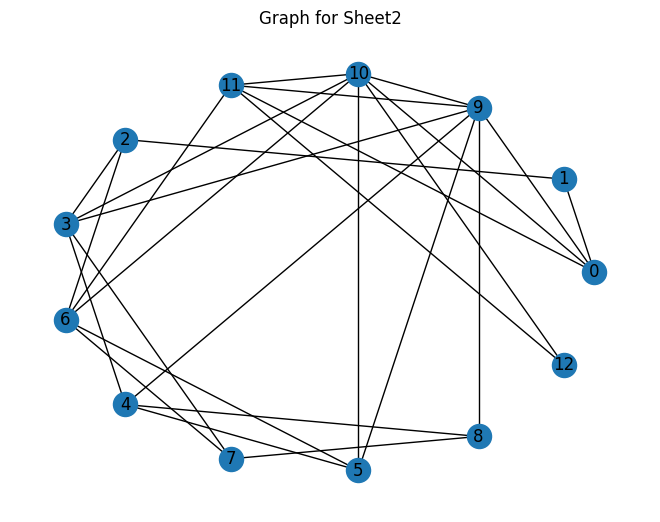

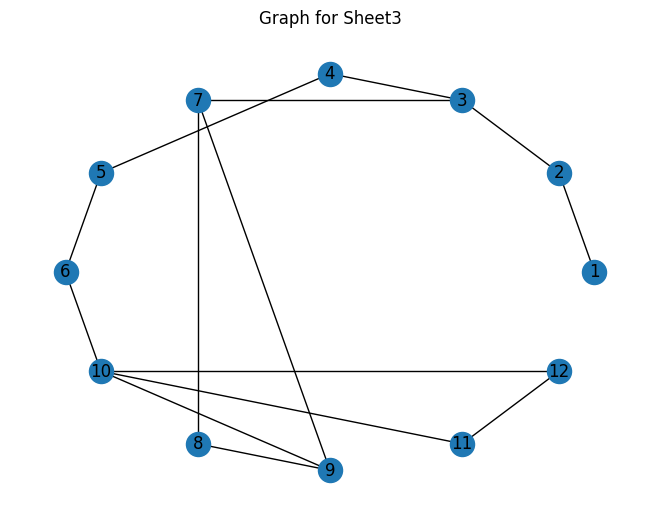

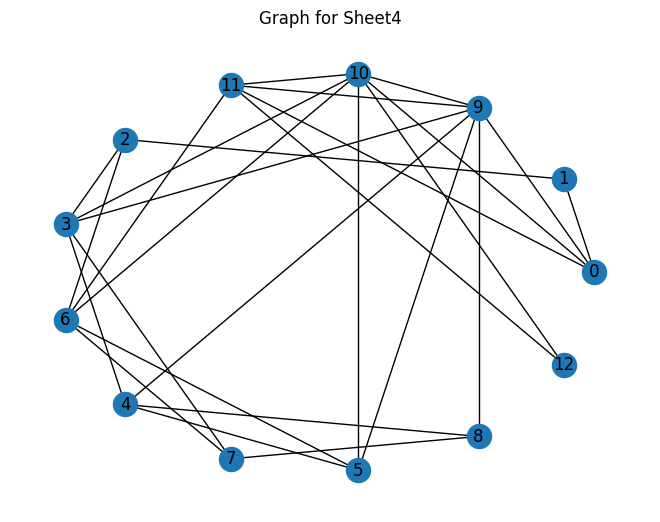

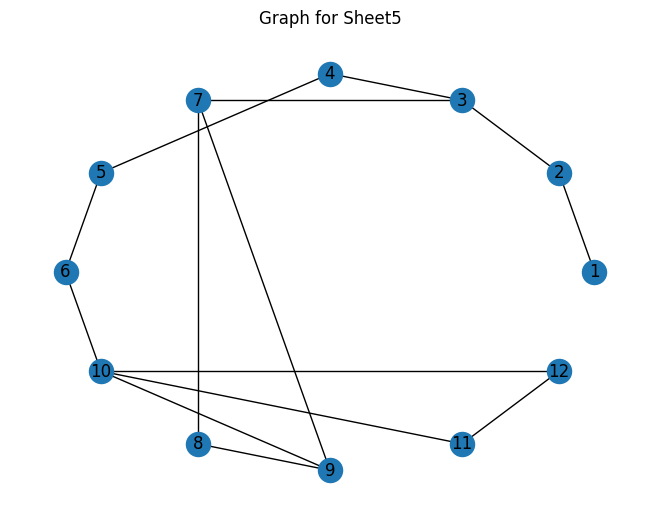

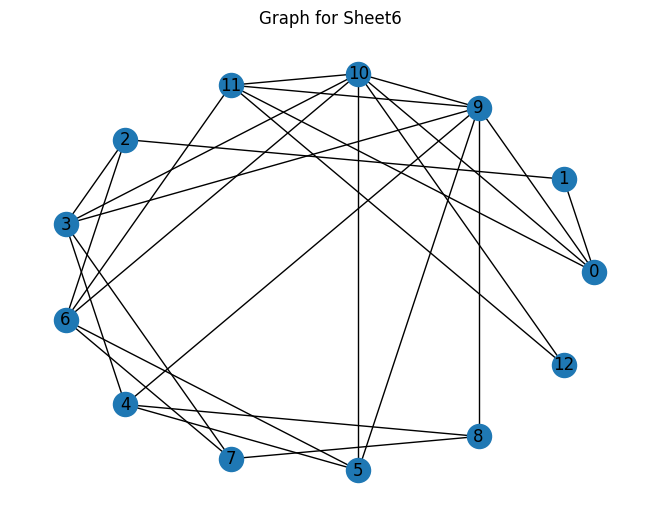

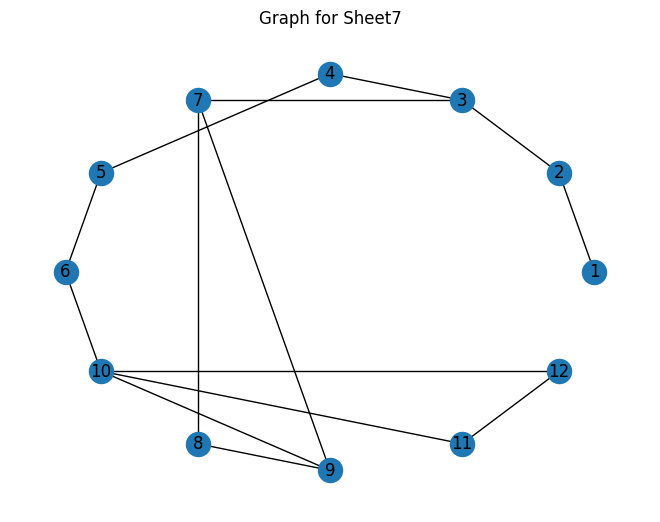

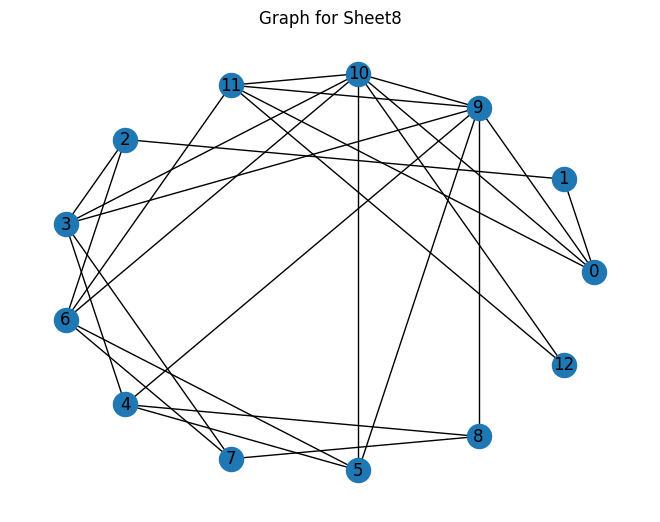

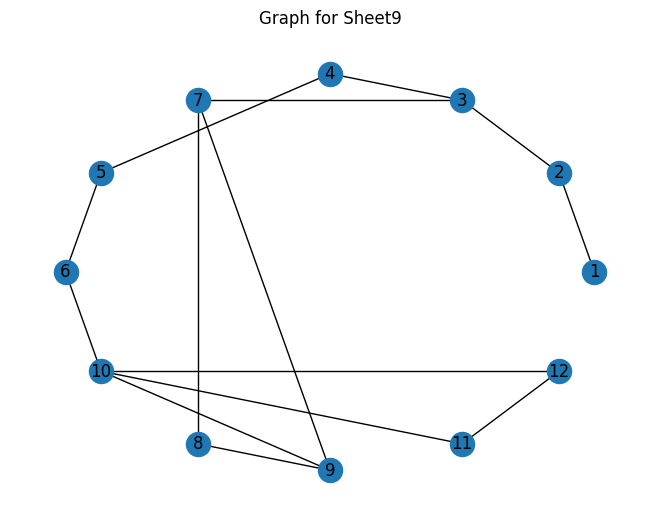

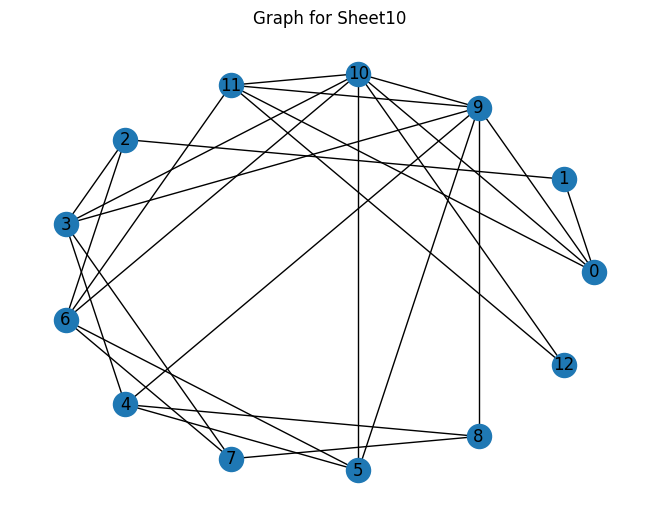

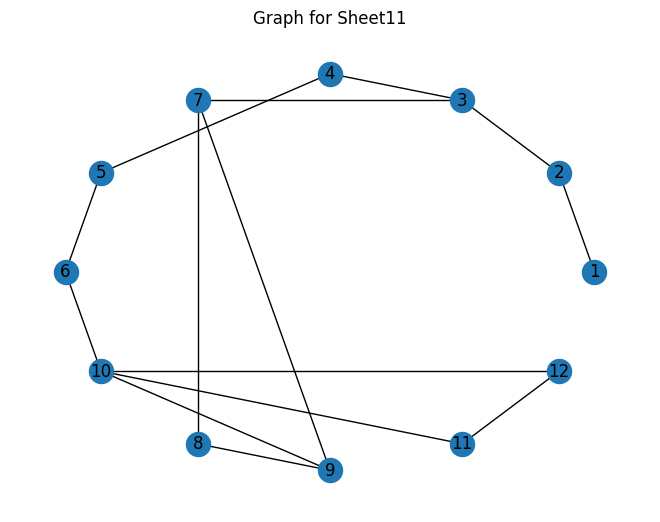

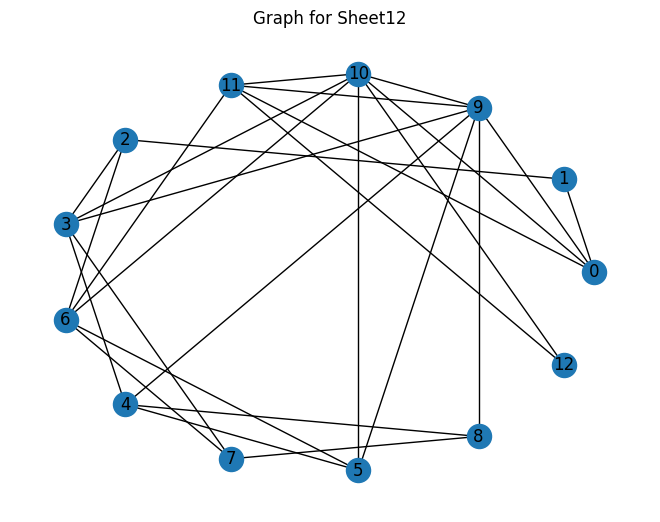

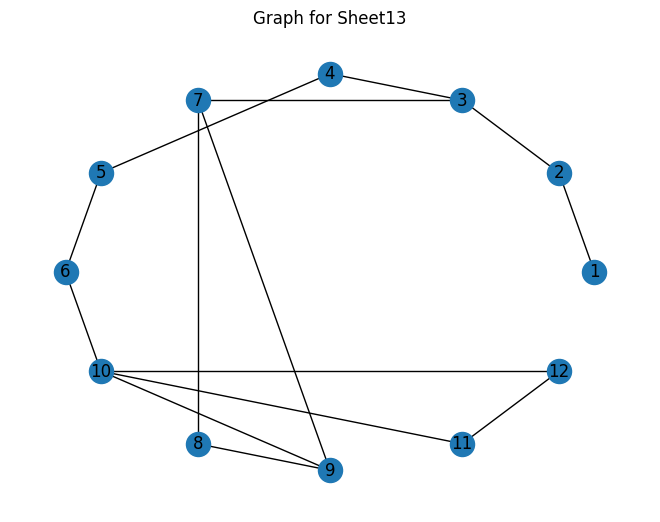

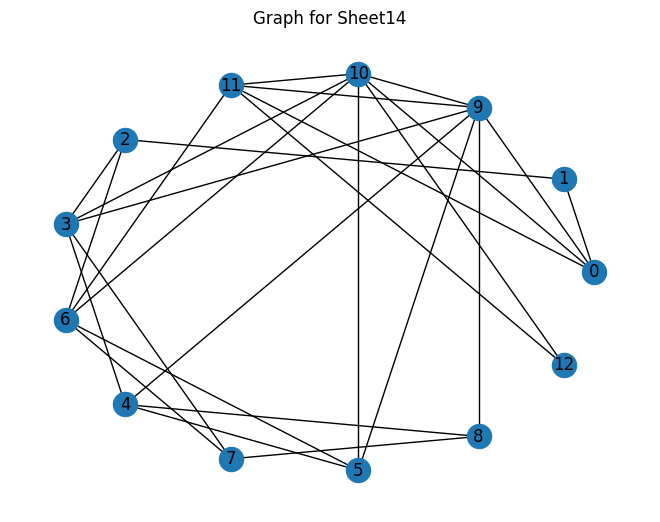

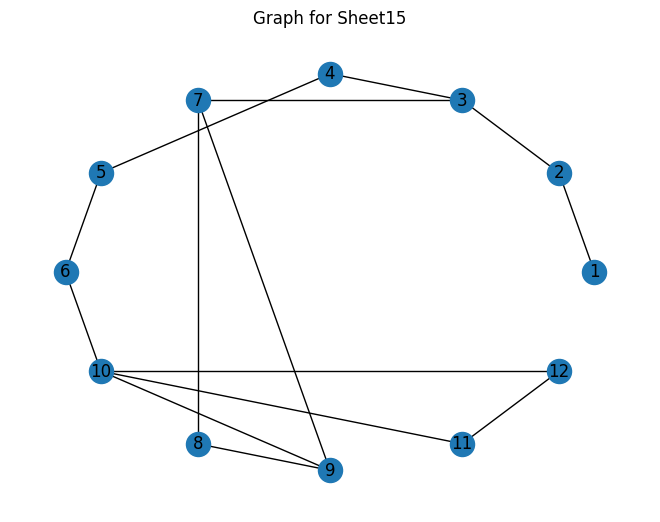

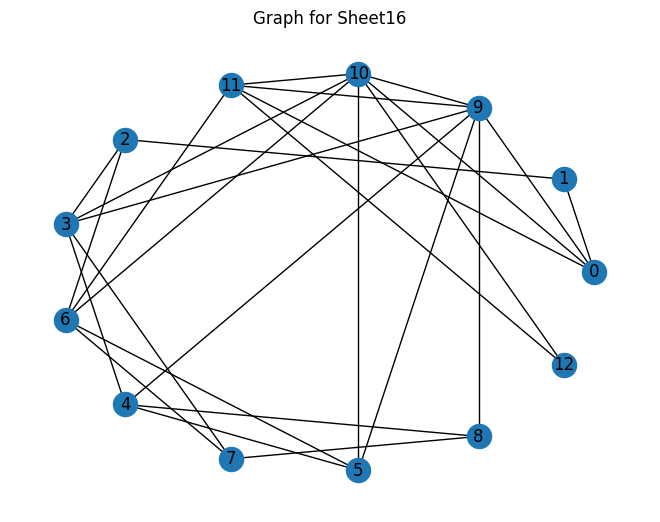

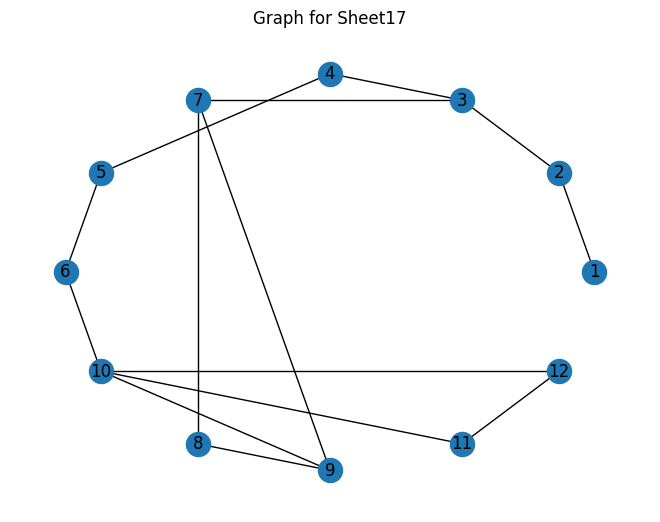

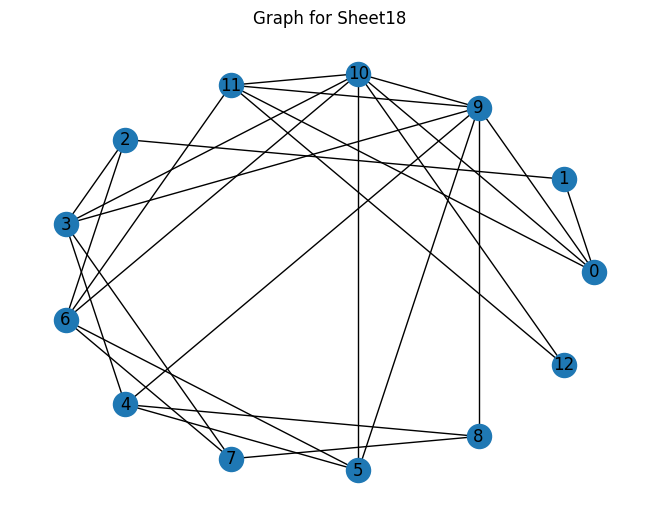

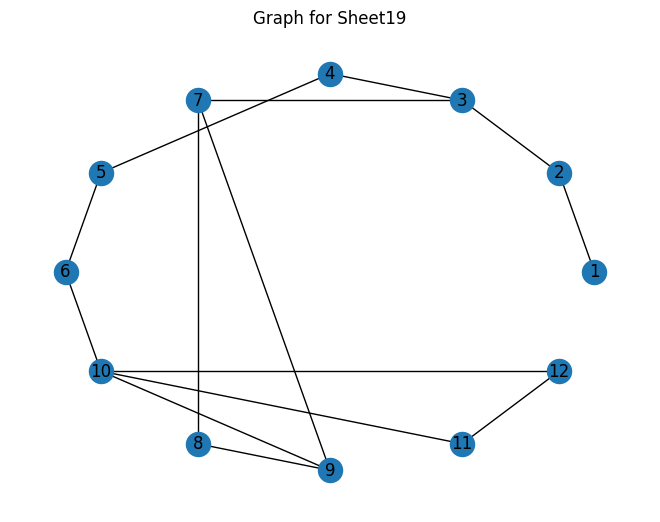

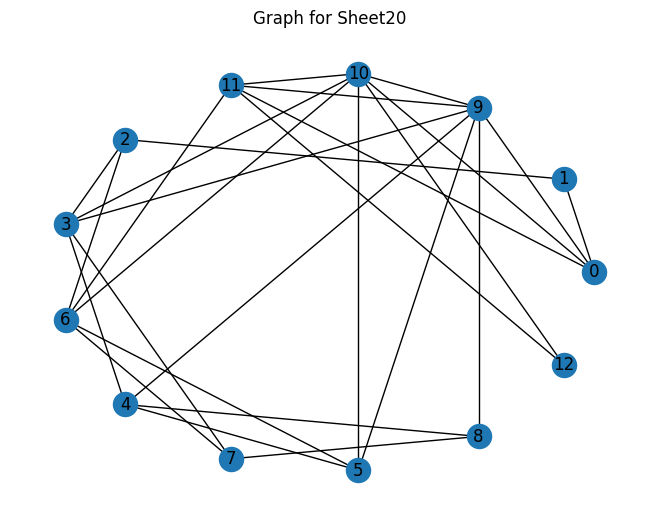

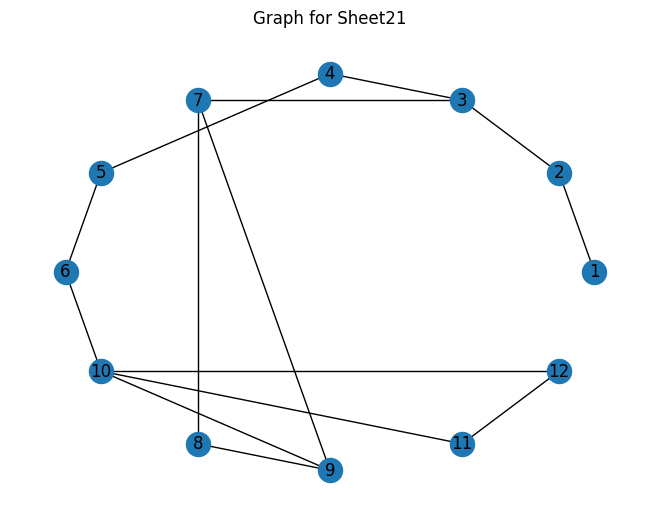

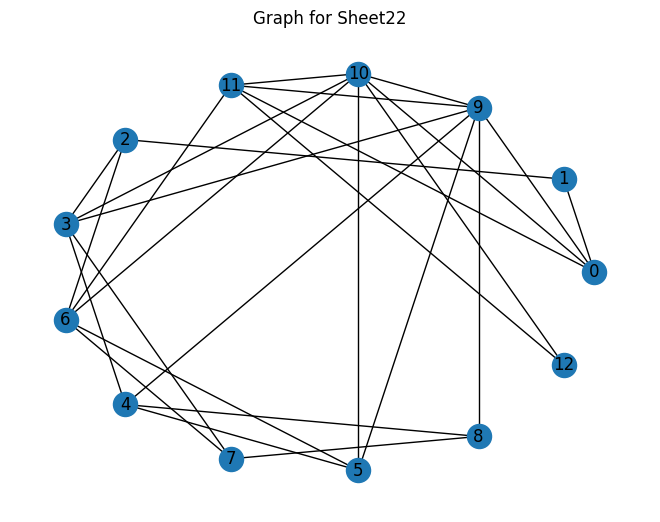

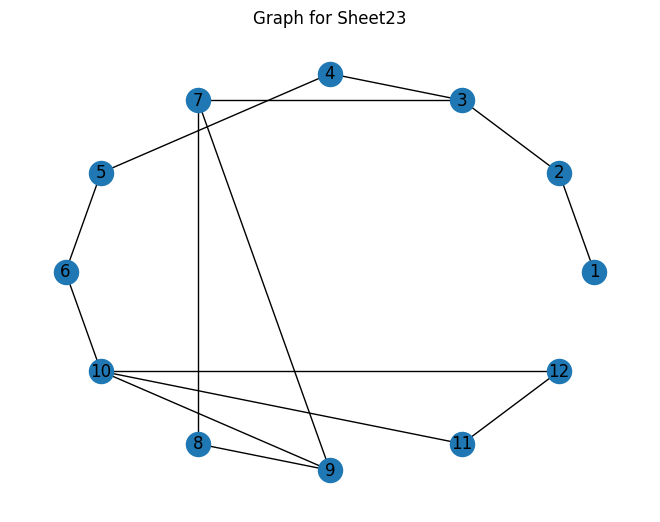

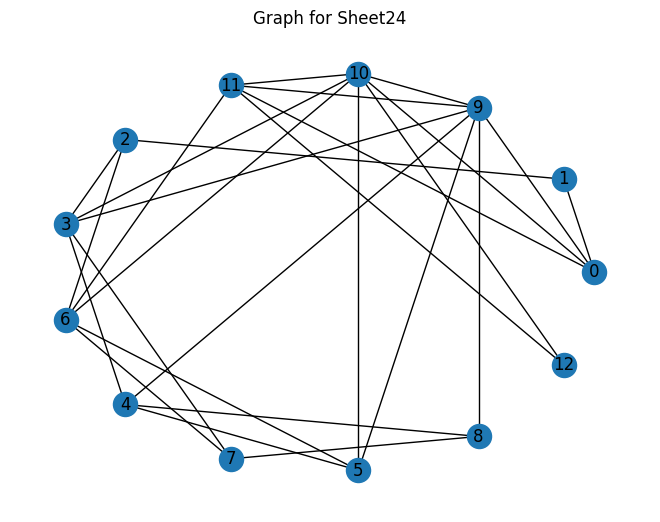

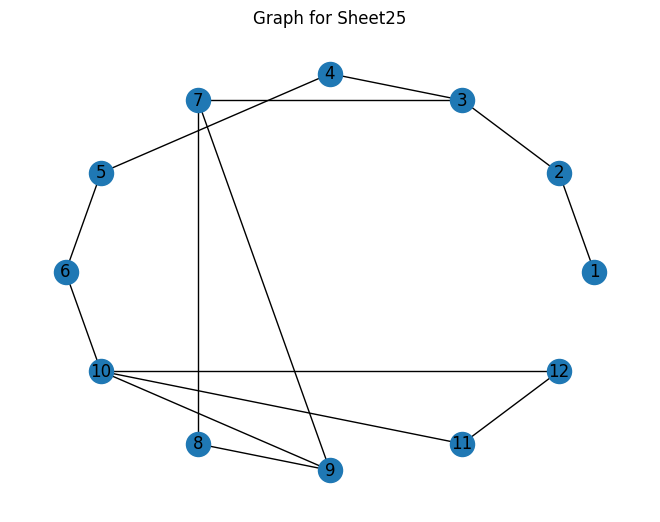

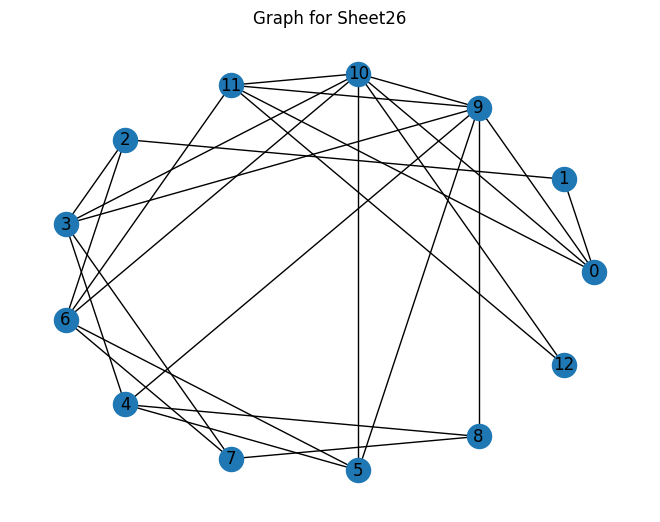

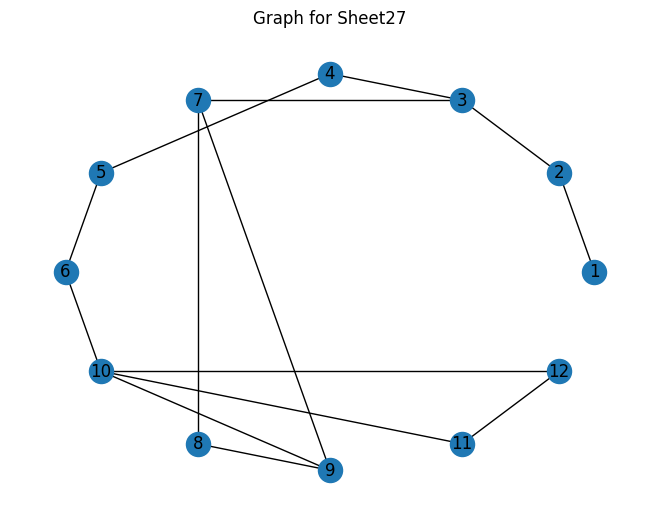

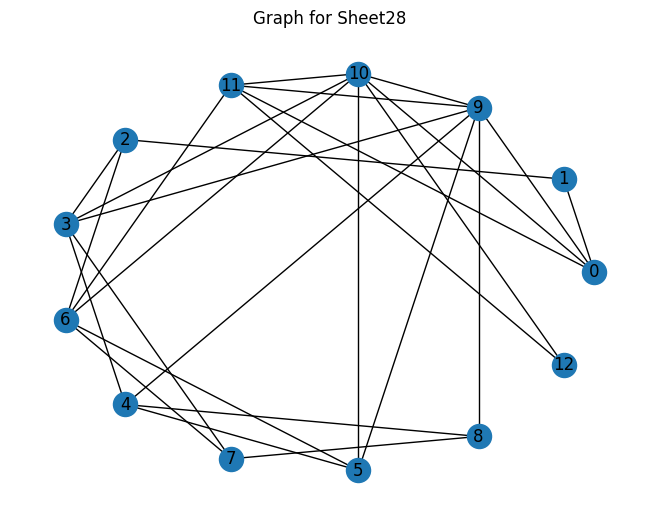

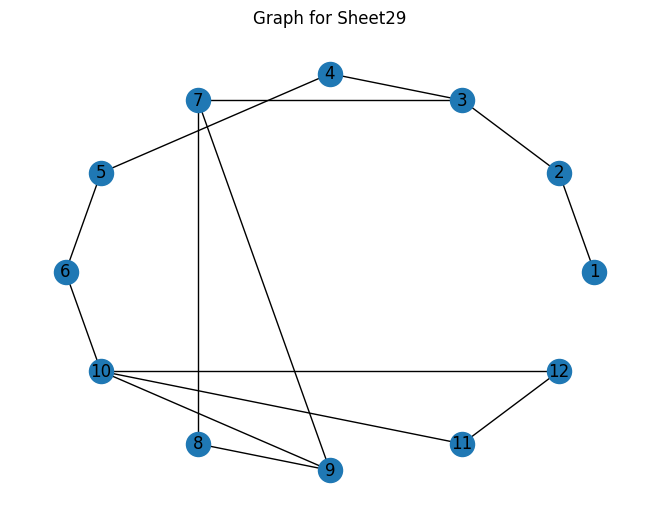

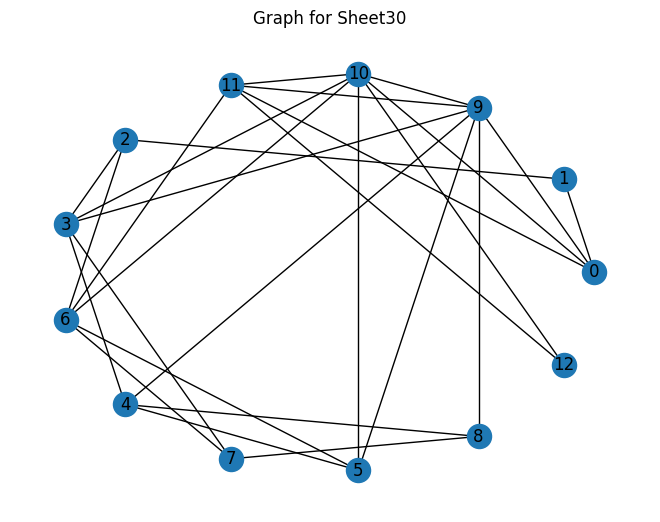

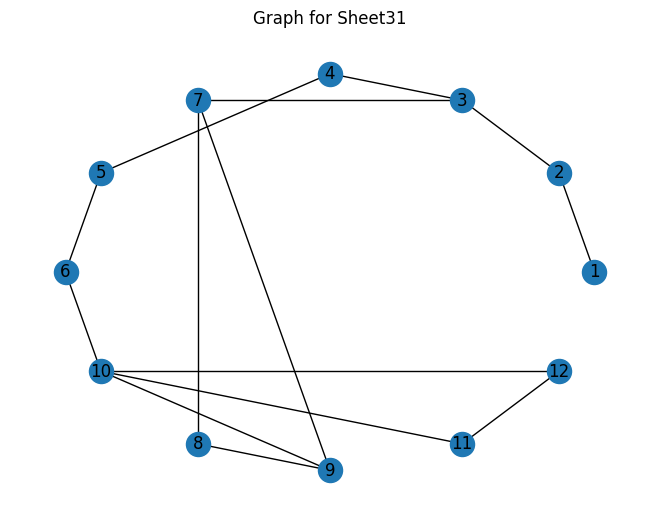

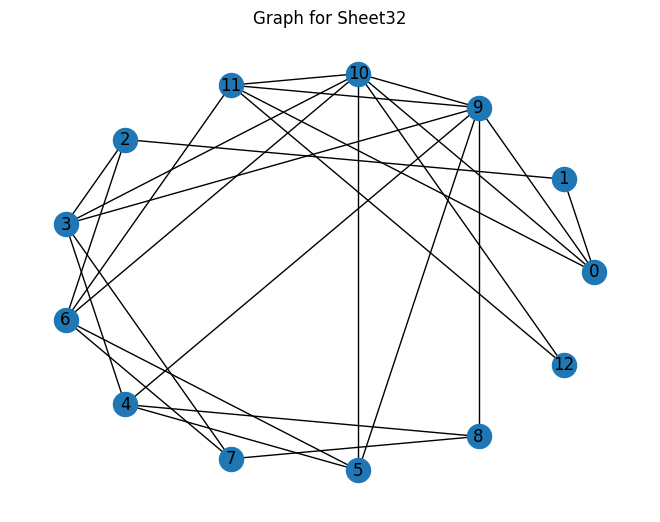

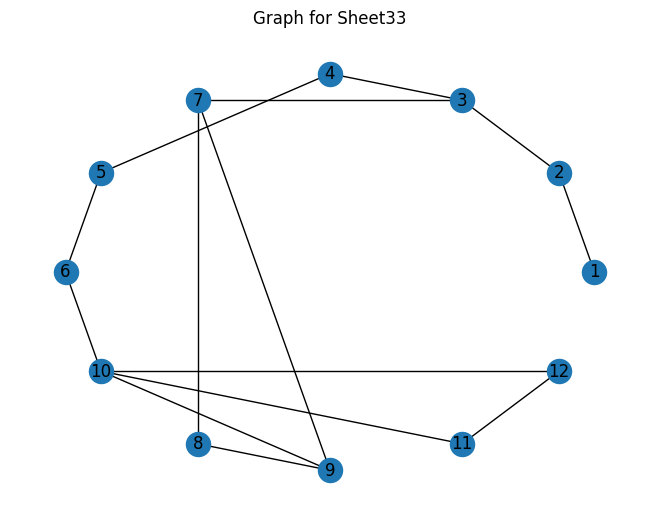

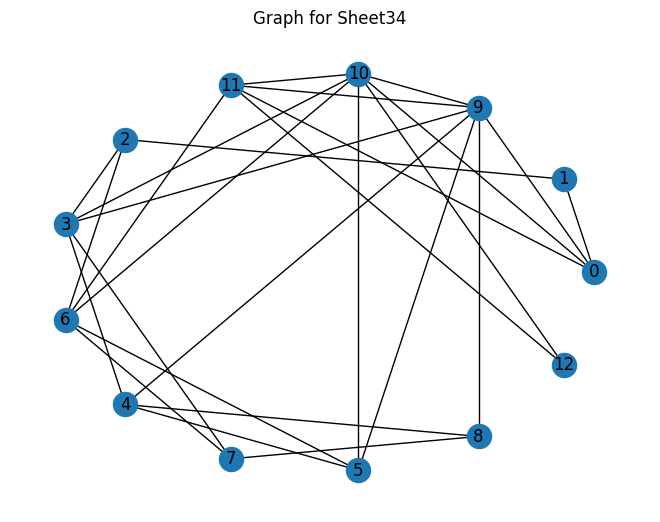

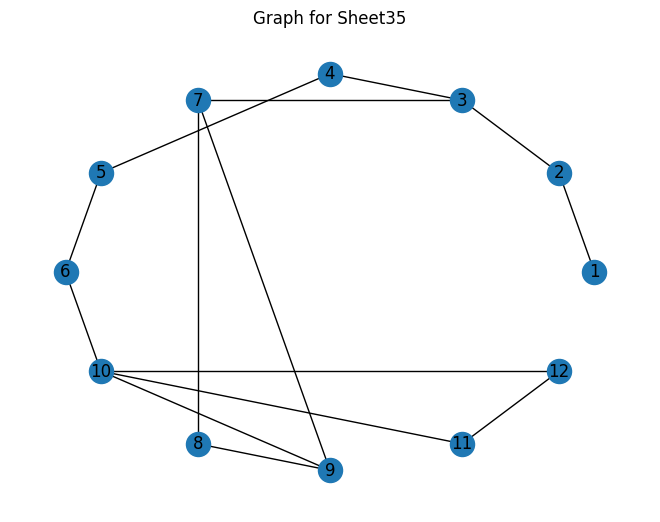

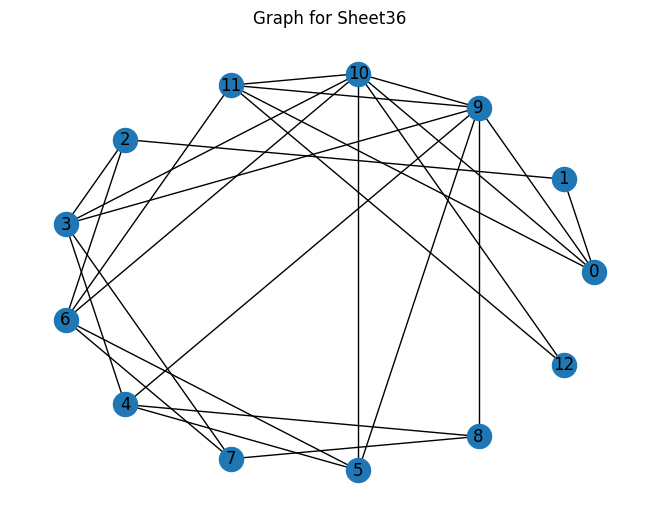

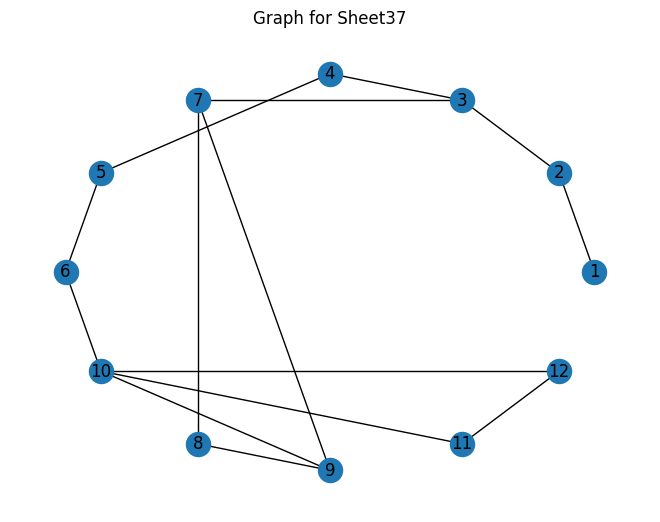

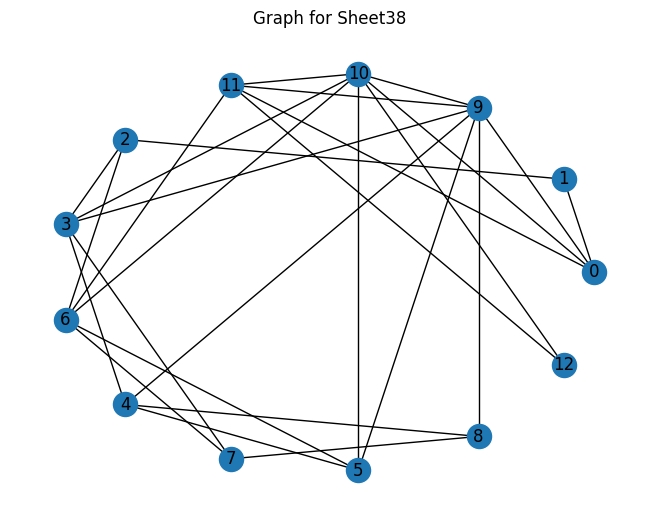

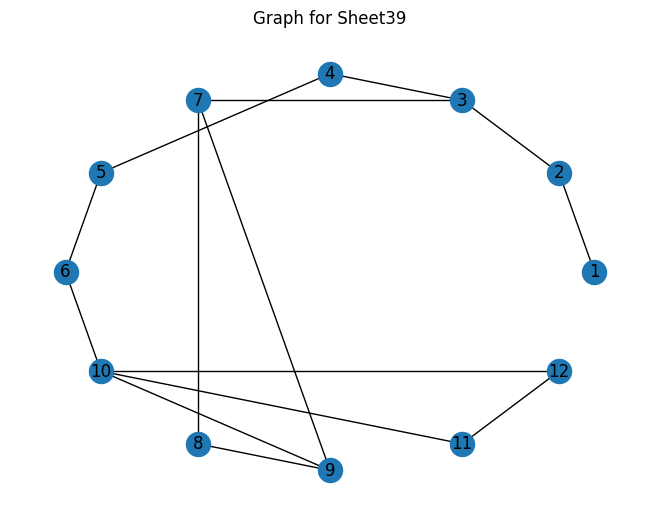

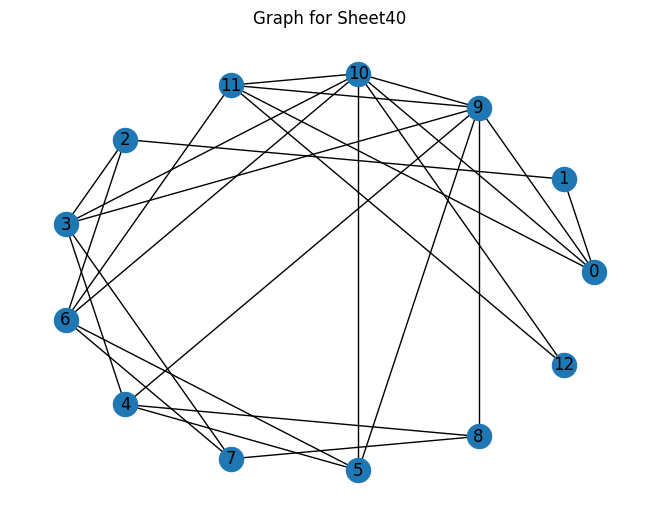

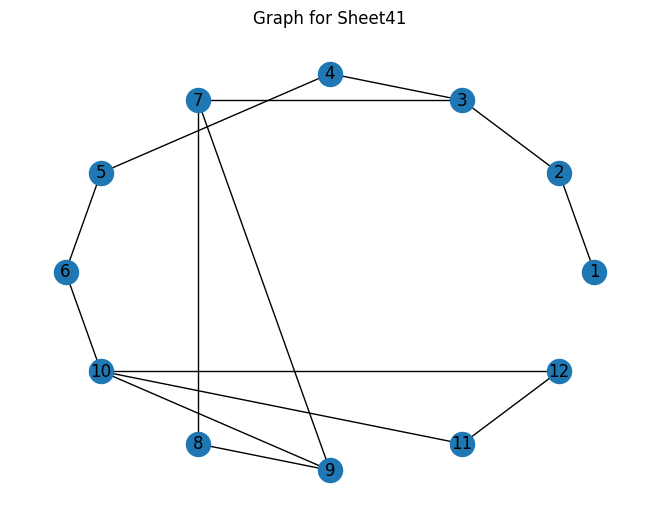

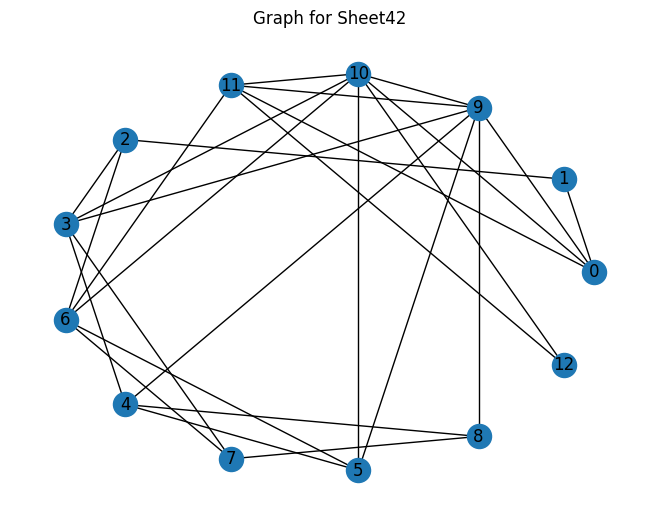

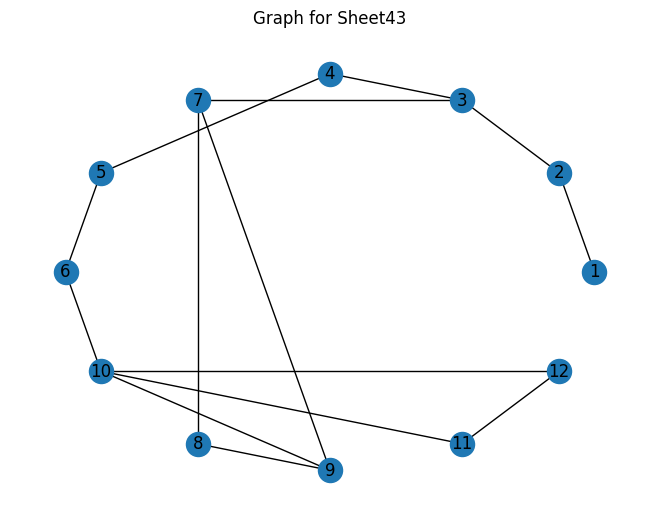

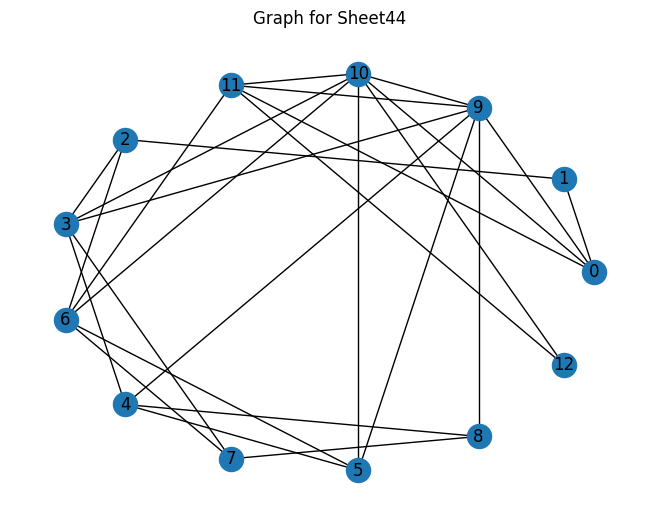

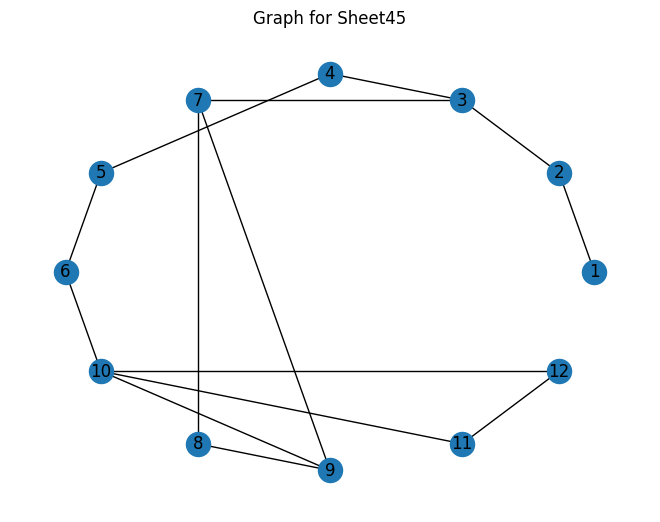

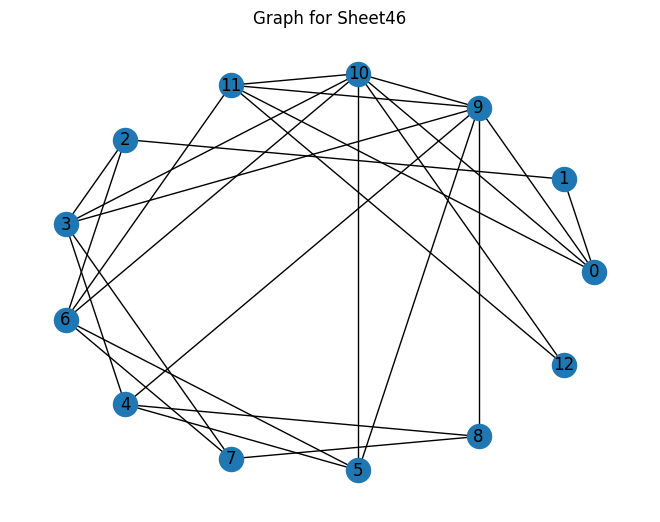

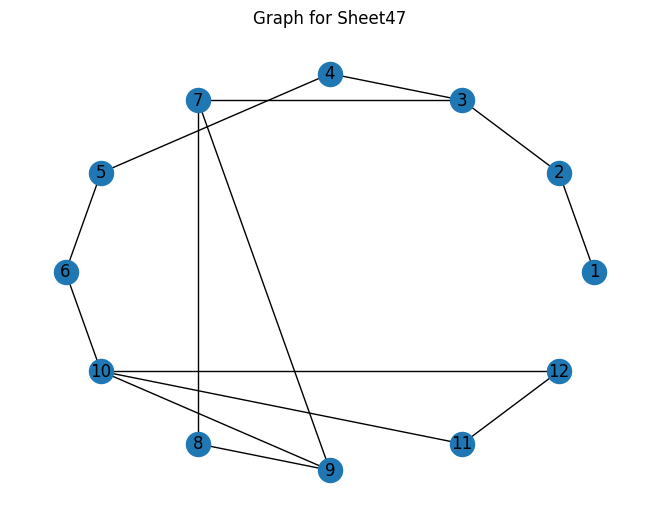

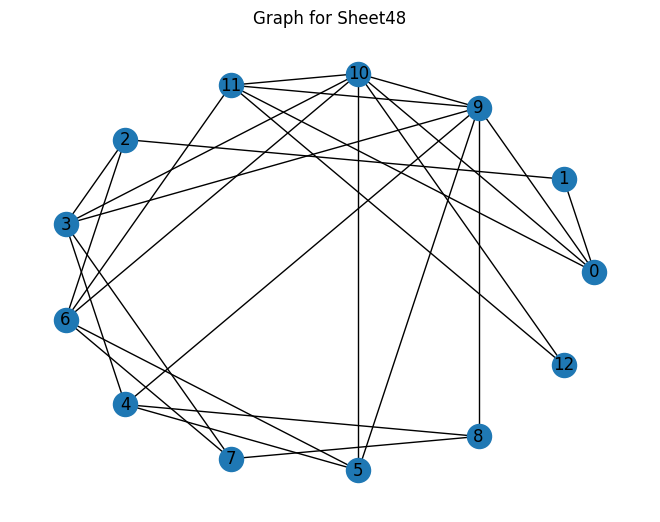

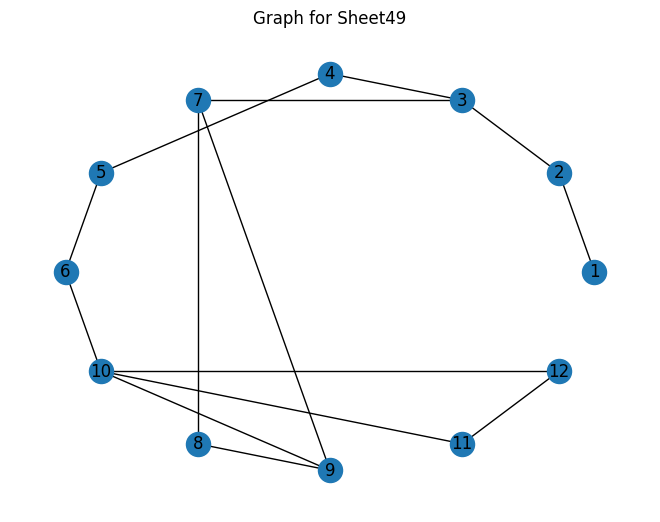

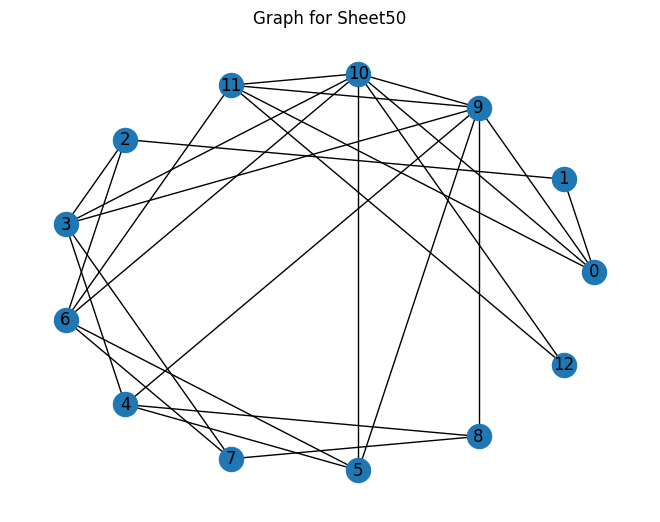

Binary matrices saved to /content/binary_matrices_neutral.xlsx
Graphs saved to /content/graphs


In [ ]:
#Step6: Graph generation using networkx

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os

# Read the Excel file with multiple sheets
input_file_path = '/content/Neutral_correlation_merged.xlsx'
xls_input = pd.ExcelFile(input_file_path)

# Create a new Excel file to store the binary matrices
output_excel_path = '/content/binary_matrices_neutral.xlsx'
output_graph_path = '/content/graphs'
os.makedirs(output_graph_path, exist_ok=True)

with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:

    # Iterate through all sheet names
    for sheet_name in xls_input.sheet_names:
        # Read the DataFrame from the current sheet
        df = xls_input.parse(sheet_name)

        # Convert the DataFrame to a NumPy array
        mat = df.to_numpy()

        # Get the dimensions of the matrix
        m, n = mat.shape[0], mat.shape[1]

        # Create a list to store the binary matrix
        lst = [[0 for _ in range(n)] for _ in range(m)]

        # Iterate over the matrix and convert values above the threshold to 1 and values below the threshold to 0
        for i in range(m):
            for j in range(n):
                if mat[i][j] > 0.5:
                    lst[i][j] = 1
                else:
                    lst[i][j] = 0

        # Convert the list to a NumPy array
        out = np.array(lst)

        # Save the binary matrix as a sheet in the new Excel file
        binary_df = pd.DataFrame(out)
        binary_df.to_excel(writer, sheet_name=sheet_name, index=False)

        # Generate a graph
        g = nx.Graph()
        nodes = list(range(m))
        for i in nodes:
            for j in range(n):
                if out[i][j] == 1 and i != j:
                    g.add_edge(i, j)

        # Draw the graph for the current sheet and show it
        plt.figure()
        nx.draw_circular(g, with_labels=True)
        plt.title(f'Graph for {sheet_name}')

        # Save the graph as a PNG file
        graph_file_path = os.path.join(output_graph_path, f'graph_{sheet_name}.png')
        plt.savefig(graph_file_path)

        # Display the graph
        plt.show()
        plt.close()

print(f'Binary matrices saved to {output_excel_path}')
print(f'Graphs saved to {output_graph_path}')


In [ ]:
!pip install networkx

Node 0 in Sheet1: Degree Centrality = 0.3333333333333333
Node 1 in Sheet1: Degree Centrality = 0.16666666666666666
Node 9 in Sheet1: Degree Centrality = 0.5833333333333333
Node 10 in Sheet1: Degree Centrality = 0.5833333333333333
Node 11 in Sheet1: Degree Centrality = 0.41666666666666663
Node 2 in Sheet1: Degree Centrality = 0.25
Node 3 in Sheet1: Degree Centrality = 0.41666666666666663
Node 6 in Sheet1: Degree Centrality = 0.41666666666666663
Node 4 in Sheet1: Degree Centrality = 0.3333333333333333
Node 7 in Sheet1: Degree Centrality = 0.25
Node 5 in Sheet1: Degree Centrality = 0.3333333333333333
Node 8 in Sheet1: Degree Centrality = 0.25
Node 12 in Sheet1: Degree Centrality = 0.16666666666666666
Node 0 in Sheet1: Betweenness Centrality = 0.09343434343434343
Node 1 in Sheet1: Betweenness Centrality = 0.015151515151515152
Node 9 in Sheet1: Betweenness Centrality = 0.18661616161616162
Node 10 in Sheet1: Betweenness Centrality = 0.16136363636363638
Node 11 in Sheet1: Betweenness Centrali

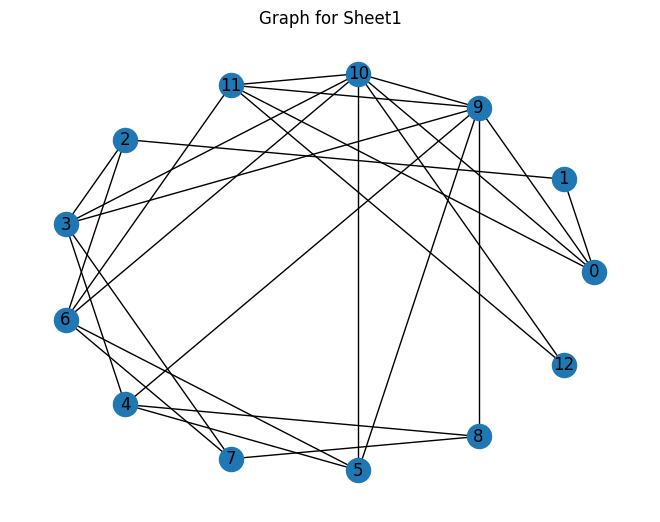

InvalidWorksheetName: Excel worksheet name 'Sheet1 (2)_betweenness_centrality' must be <= 31 chars.

In [ ]:
#Step7: Betweenness centrality and Degree centrality

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os

# Read the Excel file with multiple sheets
input_file_path = '/content/neutral_correlation_merged.xlsx'
xls_input = pd.ExcelFile(input_file_path)

# Create new Excel files to store degree and betweenness centrality
degree_output_excel_path = '/content/netural_degree_centrality_merged.xlsx'
betweenness_output_excel_path = '/content/netural_betweenness_centrality_merged.xlsx'
output_graph_path = '/content/graphs'
os.makedirs(output_graph_path, exist_ok=True)

with pd.ExcelWriter(degree_output_excel_path, engine='xlsxwriter') as degree_writer, \
     pd.ExcelWriter(betweenness_output_excel_path, engine='xlsxwriter') as betweenness_writer:

    # Iterate through all sheet names
    for sheet_name in xls_input.sheet_names:
        # Read the DataFrame from the current sheet
        df = xls_input.parse(sheet_name)

        # Convert the DataFrame to a NumPy array
        mat = df.to_numpy()

        # Get the dimensions of the matrix
        m, n = mat.shape[0], mat.shape[1]

        # Create a list to store the binary matrix
        lst = [[0 for _ in range(n)] for _ in range(m)]

        # Iterate over the matrix and convert values above the threshold to 1 and values below the threshold to 0
        for i in range(m):
            for j in range(n):
                if mat[i][j] > 0.5:
                    lst[i][j] = 1
                else:
                    lst[i][j] = 0

        # Convert the list to a NumPy array
        out = np.array(lst)

        # Generate a graph
        g = nx.Graph()
        nodes = list(range(m))
        for i in nodes:
            for j in range(n):
                if out[i][j] == 1 and i != j:
                    g.add_edge(i, j)

        # Calculate degree centrality for each node
        degree_centrality = nx.degree_centrality(g)

        # Calculate betweenness centrality for each node
        betweenness_centrality = nx.betweenness_centrality(g)

        # Create DataFrames for degree and betweenness centrality
        degree_centrality_df = pd.DataFrame(list(degree_centrality.items()), columns=['Node', 'Degree Centrality'])
        betweenness_centrality_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['Node', 'Betweenness Centrality'])

        # Save degree centrality to the degree Excel file
        degree_centrality_df.to_excel(degree_writer, sheet_name=f"{sheet_name}_degree_centrality", index=False)

        # Save betweenness centrality to the betweenness Excel file
        betweenness_centrality_df.to_excel(betweenness_writer, sheet_name=f"{sheet_name}_betweenness_centrality", index=False)

        # Print degree and betweenness centrality for each node
        for node, degree_cent in degree_centrality.items():
            print(f"Node {node} in {sheet_name}: Degree Centrality = {degree_cent}")

        for node, betweenness_cent in betweenness_centrality.items():
            print(f"Node {node} in {sheet_name}: Betweenness Centrality = {betweenness_cent}")

        # Draw the graph for the current sheet and show it
        plt.figure()
        nx.draw_circular(g, with_labels=True)
        plt.title(f'Graph for {sheet_name}')

        # Save the graph as a PNG file
        graph_file_path = os.path.join(output_graph_path, f'graph_{sheet_name}.png')
        plt.savefig(graph_file_path)

        # Display the graph
        plt.show()
        plt.close()

print(f'Degree centrality saved to {degree_output_excel_path}')
print(f'Betweenness centrality saved to {betweenness_output_excel_path}')
print(f'Graphs saved to {output_graph_path}')


In [ ]:
import pandas as pd

def generate_extra_neutral_datasets(input_file_path, sheet_names, output_file_path):
    with pd.ExcelWriter(output_file_path, engine='openpyxl') as writer:
        for sheet_name in sheet_names:
            # Read the Excel file into a pandas DataFrame
            df = pd.read_excel(input_file_path, sheet_name=sheet_name)

            # Add a value to each element in the DataFrame
            df_modified = df - 0.00044

            # Write the modified DataFrame to the same sheet in the Excel file
            df_modified.to_excel(writer, sheet_name=sheet_name, index=False)
            print(f"Data for {sheet_name} saved.")

# Example usage:
input_file_path = '/content/NEUTRAL_FILTERED_DATA.xlsx'
sheet_names = ["Q1", "Q6"]  # List of sheet names
output_file_path = 'Neutral_Extra(1).xlsx'
generate_extra_neutral_datasets(input_file_path, sheet_names, output_file_path)


Data for Q1 saved.
Data for Q6 saved.


In [ ]:
#for generating extra neutral datasets

import pandas as pd

# Replace 'your_file.xlsx' with the actual file name
#file_path = ('/content/output_filtered_elliptical.xlsx', sheet_name="Q6")

# Read the Excel file into a pandas DataFrame
df = pd.read_excel('/content/neutral fresh data.xlsx', sheet_name="Q6")

# Add 0.0005 to each element in the DataFrame
df += 0.00464

# Save the updated DataFrame to a new Excel file
# Replace 'output_file.xlsx' with the desired output file name
output_file_path = 'neutral_Q6_24.xlsx'
df.to_excel(output_file_path, index=False)

print(f"Updated Excel file saved to: {output_file_path}")


Updated Excel file saved to: neutral_Q6_24.xlsx


In [ ]:
#Step8: Using SVM for classification(adjacency matrix)

from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Load data from Excel files
afraid_data = pd.read_excel("/content/For afraid_adj.xlsx", sheet_name=None)
neutral_data = pd.read_excel("/content/for neutral_adj.xlsx", sheet_name=None)
happy_data = pd.read_excel("/content/for happy_adj.xlsx", sheet_name=None)

# Combine data from all sheets into feature vectors and labels
X = []
y = []

for class_label, data in zip(['Afraid', 'Neutral', 'Happy'], [afraid_data, neutral_data, happy_data]):
    for sheet_name, adjacency_matrix in data.items():
        flattened_matrix = np.array(adjacency_matrix).flatten()
        X.append(flattened_matrix)
        y.append(class_label)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use a radial basis function (RBF) kernel and tune hyperparameters
clf = svm.SVC(kernel='rbf', C=1.0, gamma='scale')

# Train the classifier
clf.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = clf.predict(X_test_scaled)

# Evaluate the model
cm = confusion_matrix(y_test, predictions)
accuracy = np.trace(cm) / np.sum(cm)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)

# Print classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Scale the entire feature set for cross-validation
X_scaled = scaler.transform(X)

# Cross-validation
cv_accuracy = cross_val_score(clf, X_scaled, y, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy:", np.mean(cv_accuracy))


Confusion Matrix:
[[7 1 0]
 [4 3 0]
 [0 0 3]]
Accuracy: 0.7222222222222222

Classification Report:
              precision    recall  f1-score   support

      Afraid       0.64      0.88      0.74         8
       Happy       0.75      0.43      0.55         7
     Neutral       1.00      1.00      1.00         3

    accuracy                           0.72        18
   macro avg       0.80      0.77      0.76        18
weighted avg       0.74      0.72      0.71        18


Cross-Validation Accuracy: 0.6333333333333334


Confusion Matrix:
[[7 1 0]
 [4 3 0]
 [0 0 3]]

Normalized Confusion Matrix:
[[0.875      0.125      0.        ]
 [0.57142857 0.42857143 0.        ]
 [0.         0.         1.        ]]
Overall Accuracy: 0.7222222222222222

Classification Report:
              precision    recall  f1-score   support

      Afraid       0.64      0.88      0.74         8
     Neutral       0.75      0.43      0.55         7
       Happy       1.00      1.00      1.00         3

    accuracy                           0.72        18
   macro avg       0.80      0.77      0.76        18
weighted avg       0.74      0.72      0.71        18


Individual Accuracies:
Afraid: 8.0
Neutral: 7.0
Happy: 3.0

Cross-Validation Accuracy: 0.6333333333333334


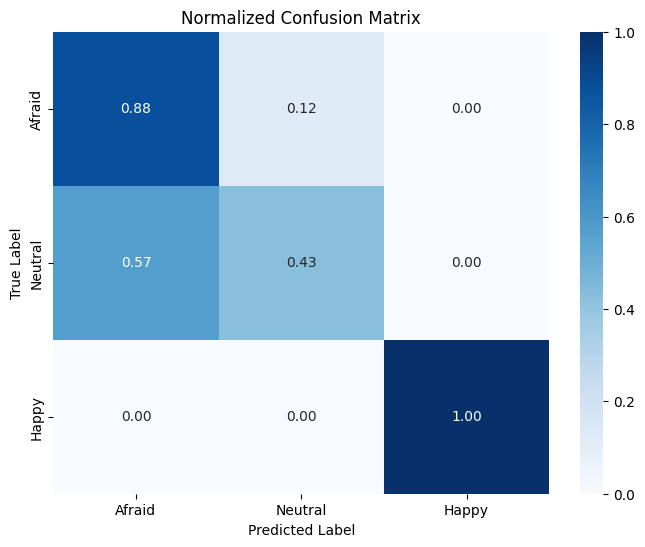

In [ ]:
#Normalized confusion matrix(adjacency matrix)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Load data from Excel files
afraid_data = pd.read_excel("/content/For afraid_adj.xlsx", sheet_name=None)
neutral_data = pd.read_excel("/content/for neutral_adj.xlsx", sheet_name=None)
happy_data = pd.read_excel("/content/for happy_adj.xlsx", sheet_name=None)

# Combine data from all sheets into feature vectors and labels
X = []
y = []

for class_label, data in zip(['Afraid', 'Neutral', 'Happy'], [afraid_data, neutral_data, happy_data]):
    for sheet_name, adjacency_matrix in data.items():
        flattened_matrix = np.array(adjacency_matrix).flatten()
        X.append(flattened_matrix)
        y.append(class_label)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use a radial basis function (RBF) kernel and tune hyperparameters
clf = svm.SVC(kernel='rbf', C=1.0, gamma='scale')

# Train the classifier
clf.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = clf.predict(X_test_scaled)

# Evaluate the model
cm = confusion_matrix(y_test, predictions)

# Calculate the normalized confusion matrix
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

print("Confusion Matrix:")
print(cm)
print("\nNormalized Confusion Matrix:")
print(normalized_cm)

accuracy = np.trace(cm) / np.sum(cm)
print("Overall Accuracy:", accuracy)

# Print classification report for detailed metrics
print("\nClassification Report:")
class_report = classification_report(y_test, predictions, target_names=['Afraid', 'Neutral', 'Happy'])
print(class_report)

# Extract individual accuracies for each class
class_accuracies = {}
for line in class_report.split('\n')[2:-5]:
    values = line.split()
    class_name = values[0]
    accuracy = float(values[-1])
    class_accuracies[class_name] = accuracy

print("\nIndividual Accuracies:")
for class_name, acc in class_accuracies.items():
    print(f"{class_name}: {acc}")

# Scale the entire feature set for cross-validation
X_scaled = scaler.transform(X)

# Cross-validation
cv_accuracy = cross_val_score(clf, X_scaled, y, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy:", np.mean(cv_accuracy))

#normalized plot for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', fmt=".2f", xticklabels=['Afraid', 'Neutral', 'Happy'], yticklabels=['Afraid', 'Neutral', 'Happy'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
#interleaved data of degree and betweenness centrality

import os
import pandas as pd

# Replace 'your_file.xlsx' with the actual path to your Excel file
file_path = '/content/Book6.xlsx'
output_file = 'interleaved_result6.xlsx'

# Read the Excel file into a dictionary of DataFrames, where keys are sheet names
dfs = pd.read_excel(file_path, sheet_name=None)

# Interleave and save each sheet separately
for sheet_name, df in dfs.items():
    # Interleaving or zipping the columns
    result = [val for pair in zip(df['Degree Centrality'], df['Betweenness Centrality']) for val in pair]

    # Create a new DataFrame with the interleaved values
    result_df = pd.DataFrame({'result': result})

    # Save the result to a new sheet in the same Excel file or create the file if it doesn't exist
    mode = 'a' if os.path.exists(output_file) else 'w'
    with pd.ExcelWriter(output_file, engine='openpyxl', mode=mode) as writer:
        result_df.to_excel(writer, sheet_name=sheet_name + '_interleaved', index=False)

    # Display the result DataFrame
    print(f"Interleaved result for sheet '{sheet_name}':")
    print(result_df)


Interleaved result for sheet 'Sheet1':
      result
0   0.090909
1   0.000000
2   0.181818
3   0.181818
4   0.181818
5   0.327273
6   0.181818
7   0.436364
8   0.181818
9   0.509091
10  0.363636
11  0.609091
12  0.181818
13  0.118182
14  0.181818
15  0.018182
16  0.181818
17  0.045455
18  0.363636
19  0.236364
20  0.272727
21  0.063636
22  0.181818
23  0.000000
Interleaved result for sheet 'Sheet2':
      result
0   0.090909
1   0.000000
2   0.181818
3   0.181818
4   0.181818
5   0.327273
6   0.181818
7   0.436364
8   0.181818
9   0.509091
10  0.363636
11  0.609091
12  0.181818
13  0.118182
14  0.181818
15  0.018182
16  0.181818
17  0.045455
18  0.363636
19  0.236364
20  0.272727
21  0.063636
22  0.181818
23  0.000000
Interleaved result for sheet 'Sheet3':
      result
0   0.090909
1   0.000000
2   0.181818
3   0.181818
4   0.181818
5   0.327273
6   0.181818
7   0.436364
8   0.181818
9   0.509091
10  0.363636
11  0.609091
12  0.181818
13  0.118182
14  0.181818
15  0.018182
16  0.181818

In [ ]:
#Step8: Using SVM for classfication(centrality)

from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Load data from Excel files
afraid_data = pd.read_excel("/content/afraid_centrality.xlsx", sheet_name=None)
neutral_data = pd.read_excel("/content/neutral_centrality.xlsx", sheet_name=None)
happy_data = pd.read_excel("/content/happy_centrality.xlsx", sheet_name=None)

# Combine data from all sheets into feature vectors and labels
X = []
y = []

# Find the maximum length of feature vectors
max_length = max(len(np.array(centrality_values).flatten()) for data in [afraid_data, neutral_data, happy_data] for centrality_values in data.values())

for class_label, data in zip(['Afraid', 'Neutral', 'Happy'], [afraid_data, neutral_data, happy_data]):
    for sheet_name, centrality_values in data.items():
        flattened_values = np.array(centrality_values).flatten()
        # Zero-pad or truncate feature vectors to the maximum length
        padded_values = np.pad(flattened_values, (0, max_length - len(flattened_values)), 'constant')
        X.append(padded_values)
        y.append(class_label)

# Convert lists to numpy arrays
X = np.vstack(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use a radial basis function (RBF) kernel and tune hyperparameters
clf = svm.SVC(kernel='rbf', C=1.0, gamma='scale')

# Train the classifier
clf.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = clf.predict(X_test_scaled)

# Evaluate the model
cm = confusion_matrix(y_test, predictions)
accuracy = np.trace(cm) / np.sum(cm)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)

# Print classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Scale the entire feature set for cross-validation
X_scaled = scaler.transform(X)

# Cross-validation
cv_accuracy = cross_val_score(clf, X_scaled, y, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy:", np.mean(cv_accuracy))


Confusion Matrix:
[[3 5 0]
 [1 5 1]
 [0 0 3]]
Accuracy: 0.6111111111111112

Classification Report:
              precision    recall  f1-score   support

      Afraid       0.75      0.38      0.50         8
       Happy       0.50      0.71      0.59         7
     Neutral       0.75      1.00      0.86         3

    accuracy                           0.61        18
   macro avg       0.67      0.70      0.65        18
weighted avg       0.65      0.61      0.59        18


Cross-Validation Accuracy: 0.65


Confusion Matrix:
[[3 5 0]
 [1 5 1]
 [0 0 3]]
Accuracy: 0.6111111111111112

Classification Report:
              precision    recall  f1-score   support

      Afraid       0.75      0.38      0.50         8
       Happy       0.50      0.71      0.59         7
     Neutral       0.75      1.00      0.86         3

    accuracy                           0.61        18
   macro avg       0.67      0.70      0.65        18
weighted avg       0.65      0.61      0.59        18



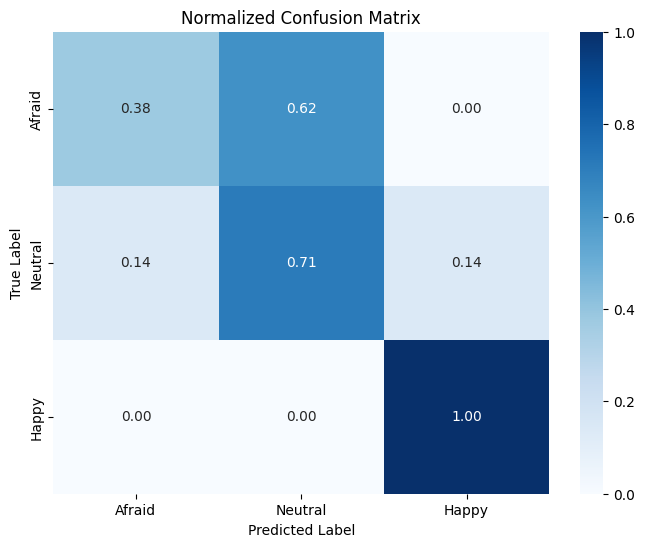


Accuracy per Class:
Afraid: 37.50%
Neutral: 71.43%
Happy: 100.00%

Cross-Validation Accuracy: 0.65


In [ ]:
#Normalised confusion matrix(centrality)

from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from Excel files
afraid_data = pd.read_excel("/content/afraid_centrality.xlsx", sheet_name=None)
neutral_data = pd.read_excel("/content/neutral_centrality.xlsx", sheet_name=None)
happy_data = pd.read_excel("/content/happy_centrality.xlsx", sheet_name=None)

# Combine data from all sheets into feature vectors and labels
X = []
y = []

# Find the maximum length of feature vectors
max_length = max(len(np.array(centrality_values).flatten()) for data in [afraid_data, neutral_data, happy_data] for centrality_values in data.values())

for class_label, data in zip(['Afraid', 'Neutral', 'Happy'], [afraid_data, neutral_data, happy_data]):
    for sheet_name, centrality_values in data.items():
        flattened_values = np.array(centrality_values).flatten()
        # Zero-pad or truncate feature vectors to the maximum length
        padded_values = np.pad(flattened_values, (0, max_length - len(flattened_values)), 'constant')
        X.append(padded_values)
        y.append(class_label)

# Convert lists to numpy arrays
X = np.vstack(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use a radial basis function (RBF) kernel and tune hyperparameters
clf = svm.SVC(kernel='rbf', C=1.0, gamma='scale')

# Train the classifier
clf.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = clf.predict(X_test_scaled)

# Evaluate the model
cm = confusion_matrix(y_test, predictions)
accuracy = np.trace(cm) / np.sum(cm)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)

# Print classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Normalize the confusion matrix
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, cmap="Blues", fmt=".2f", xticklabels=['Afraid', 'Neutral', 'Happy'], yticklabels=['Afraid', 'Neutral', 'Happy'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print accuracy per class
accuracy_per_class = np.diag(normalized_cm)
print("\nAccuracy per Class:")
for class_label, acc in zip(['Afraid', 'Neutral', 'Happy'], accuracy_per_class):
    print(f"{class_label}: {acc:.2%}")

# Scale the entire feature set for cross-validation
X_scaled = scaler.transform(X)

# Cross-validation
cv_accuracy = cross_val_score(clf, X_scaled, y, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy:", np.mean(cv_accuracy))


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load data
afraid_df = pd.read_excel("/content/afraid_gnn.xlsx")
neutral_df = pd.read_excel("/content/neutral_gnn.xlsx")
happy_df = pd.read_excel("/content/happy_gnn.xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Define your graph convolutional neural network model with Leaky ReLU
class GCN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout_rate=0.3):
        super(GCN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.activation1 = nn.LeakyReLU(0.01)  # Leaky ReLU with negative slope of 0.2
        self.dropout = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.activation2 = nn.LeakyReLU(0.01)
        self.layer3 = nn.Linear(hidden_size2, hidden_size2)  # Additional hidden layer
        self.activation3 = nn.LeakyReLU(0.01)
        self.layer4 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = self.activation1(self.layer1(x))
        x = self.dropout(x)
        x = self.activation2(self.layer2(x))
        x = self.dropout(x)
        x = self.activation3(self.layer3(x))
        x = self.layer4(x)
        return x

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model, loss function, and optimizer
model = GCN(input_size=X.shape[1], hidden_size1=128, hidden_size2=64, num_classes=3, dropout_rate=0.3)
criterion = nn.CrossEntropyLoss()

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    epochs = 50
    best_val_loss = float('inf')
    early_stopping_counter = 0
    patience = 20

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        val_loss /= len(val_loader)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")
    fold_conf_matrices.append(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, zero_division=1)
    print(f"Classification Report for Fold {fold + 1}:\n{class_report}")
    class_reports.append(class_report)

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

# Sum up confusion matrices from all folds
overall_conf_matrix = sum(fold_conf_matrices)
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Display average classification report
avg_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"], zero_division=1)
print(f"Average Classification Report:\n{avg_class_report}")

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy}")



Fold 1:
Early stopping at epoch 20
Confusion Matrix for Fold 1:
[[0 1 2]
 [0 0 2]
 [0 1 2]]
Classification Report for Fold 1:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       0.00      0.00      0.00         2
           2       0.33      0.67      0.44         3

    accuracy                           0.25         8
   macro avg       0.44      0.22      0.15         8
weighted avg       0.50      0.25      0.17         8


Fold 2:
Early stopping at epoch 20
Confusion Matrix for Fold 2:
[[0 3 0]
 [1 1 0]
 [1 1 1]]
Classification Report for Fold 2:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.20      0.50      0.29         2
           2       1.00      0.33      0.50         3

    accuracy                           0.25         8
   macro avg       0.40      0.28      0.26         8
weighted avg       0.42      0.25      

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load data
afraid_df = pd.read_excel("/content/afraid_gnn.xlsx")
neutral_df = pd.read_excel("/content/neutral_gnn.xlsx")
happy_df = pd.read_excel("/content/happy_gnn.xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Define your graph convolutional neural network model with Sigmoid activation
class GCN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout_rate=0.3):
        super(GCN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.activation1 = nn.Sigmoid()  # Sigmoid activation
        self.dropout = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.activation2 = nn.Sigmoid()
        self.layer3 = nn.Linear(hidden_size2, hidden_size2)  # Additional hidden layer
        self.activation3 = nn.Sigmoid()
        self.layer4 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = self.activation1(self.layer1(x))
        x = self.dropout(x)
        x = self.activation2(self.layer2(x))
        x = self.dropout(x)
        x = self.activation3(self.layer3(x))
        x = self.layer4(x)
        return x

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model, loss function, and optimizer
model = GCN(input_size=X.shape[1], hidden_size1=128, hidden_size2=64, num_classes=3, dropout_rate=0.3)
criterion = nn.CrossEntropyLoss()

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    epochs = 1000
    best_val_loss = float('inf')
    early_stopping_counter = 0
    patience = 70

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        val_loss /= len(val_loader)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")
    fold_conf_matrices.append(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, zero_division=1)
    print(f"Classification Report for Fold {fold + 1}:\n{class_report}")
    class_reports.append(class_report)

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

# Sum up confusion matrices from all folds
overall_conf_matrix = sum(fold_conf_matrices)
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Display average classification report
avg_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"], zero_division=1)
print(f"Average Classification Report:\n{avg_class_report}")

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy}")



Fold 1:
Early stopping at epoch 99
Confusion Matrix for Fold 1:
[[0 0 3]
 [0 0 2]
 [0 1 2]]
Classification Report for Fold 1:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       0.00      0.00      0.00         2
           2       0.29      0.67      0.40         3

    accuracy                           0.25         8
   macro avg       0.43      0.22      0.13         8
weighted avg       0.48      0.25      0.15         8


Fold 2:
Early stopping at epoch 70
Confusion Matrix for Fold 2:
[[0 0 3]
 [0 0 2]
 [0 1 2]]
Classification Report for Fold 2:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       0.00      0.00      0.00         2
           2       0.29      0.67      0.40         3

    accuracy                           0.25         8
   macro avg       0.43      0.22      0.13         8
weighted avg       0.48      0.25      

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load data
afraid_df = pd.read_excel("/content/afraid_gnn.xlsx")
neutral_df = pd.read_excel("/content/neutral_gnn.xlsx")
happy_df = pd.read_excel("/content/happy_gnn.xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Define your graph convolutional neural network model with ReLU activation
class GCN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout_rate=0.3):
        super(GCN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.activation1 = nn.ReLU()  # ReLU activation
        self.dropout = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.activation2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size2, hidden_size2)  # Additional hidden layer
        self.activation3 = nn.ReLU()
        self.layer4 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = self.activation1(self.layer1(x))
        x = self.dropout(x)
        x = self.activation2(self.layer2(x))
        x = self.dropout(x)
        x = self.activation3(self.layer3(x))
        x = self.layer4(x)
        return x

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model, loss function, and optimizer
model = GCN(input_size=X.shape[1], hidden_size1=128, hidden_size2=64, num_classes=3, dropout_rate=0.3)
criterion = nn.CrossEntropyLoss()

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    epochs = 50
    best_val_loss = float('inf')
    early_stopping_counter = 0
    patience = 70

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        val_loss /= len(val_loader)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")
    fold_conf_matrices.append(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, zero_division=1)
    print(f"Classification Report for Fold {fold + 1}:\n{class_report}")
    class_reports.append(class_report)

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

# Sum up confusion matrices from all folds
overall_conf_matrix = sum(fold_conf_matrices)
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Display average classification report
avg_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"], zero_division=1)
print(f"Average Classification Report:\n{avg_class_report}")

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy}")



Fold 1:
Confusion Matrix for Fold 1:
[[0 1 2]
 [0 0 2]
 [0 2 1]]
Classification Report for Fold 1:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       0.00      0.00      0.00         2
           2       0.20      0.33      0.25         3

    accuracy                           0.12         8
   macro avg       0.40      0.11      0.08         8
weighted avg       0.45      0.12      0.09         8


Fold 2:
Confusion Matrix for Fold 2:
[[1 2 0]
 [1 1 0]
 [2 0 1]]
Classification Report for Fold 2:
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.33      0.50      0.40         2
           2       1.00      0.33      0.50         3

    accuracy                           0.38         8
   macro avg       0.53      0.39      0.40         8
weighted avg       0.55      0.38      0.39         8


Fold 3:
Confusion Matrix for Fold 3:


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F

# Load data
afraid_df = pd.read_excel("/content/afraid_gnn.xlsx")
neutral_df = pd.read_excel("/content/neutral_gnn.xlsx")
happy_df = pd.read_excel("/content/happy_gnn.xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Define your graph convolutional neural network model with MISH activation
class GCN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout_rate=0.3):
        super(GCN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.dropout = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, hidden_size2)  # Additional hidden layer
        self.layer4 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        x = F.mish(self.layer1(x))
        x = self.dropout(x)
        x = F.mish(self.layer2(x))
        x = self.dropout(x)
        x = F.mish(self.layer3(x))
        x = self.layer4(x)
        return x

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model, loss function, and optimizer
model = GCN(input_size=X.shape[1], hidden_size1=128, hidden_size2=64, num_classes=3, dropout_rate=0.3)
criterion = nn.CrossEntropyLoss()

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    epochs = 50
    best_val_loss = float('inf')
    early_stopping_counter = 0
    patience = 70

    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        val_loss /= len(val_loader)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")
    fold_conf_matrices.append(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, zero_division=1)
    print(f"Classification Report for Fold {fold + 1}:\n{class_report}")
    class_reports.append(class_report)

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

# Sum up confusion matrices from all folds
overall_conf_matrix = sum(fold_conf_matrices)
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Display average classification report
avg_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"], zero_division=1)
print(f"Average Classification Report:\n{avg_class_report}")

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy}")



Fold 1:
Confusion Matrix for Fold 1:
[[0 1 2]
 [0 0 2]
 [0 2 1]]
Classification Report for Fold 1:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       0.00      0.00      0.00         2
           2       0.20      0.33      0.25         3

    accuracy                           0.12         8
   macro avg       0.40      0.11      0.08         8
weighted avg       0.45      0.12      0.09         8


Fold 2:
Confusion Matrix for Fold 2:
[[1 1 1]
 [1 1 0]
 [2 0 1]]
Classification Report for Fold 2:
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.50      0.50      0.50         2
           2       0.50      0.33      0.40         3

    accuracy                           0.38         8
   macro avg       0.42      0.39      0.40         8
weighted avg       0.41      0.38      0.38         8


Fold 3:
Confusion Matrix for Fold 3:


#  GNN USING RELU ACTIVATION FUNCTION

In [ ]:
from torch_geometric.data import Data

ModuleNotFoundError: No module named 'torch_geometric'

In [ ]:
import torch
edge_index = torch.tensor([[0, 1], [1, 0]], dtype=torch.long)

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load data
afraid_df = pd.read_excel("/content/afraid_gnn1.xlsx")
neutral_df = pd.read_excel("/content/netural_degree_betweeness_merged.xlsx")
happy_df = pd.read_excel("/content/happy_gnn1.xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Define your graph convolutional neural network model with ReLU activation
class GCN(torch.nn.Module):
    def __init__(self, num_features: int, hidden_dim:int, emb_dim: int, num_classes: int, seed: int = 42):
        super().__init__()
        torch.manual_seed(seed)

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, emb_dim)
        self.classifier = Linear(emb_dim, num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.conv2(h, edge_index)
        out = self.classifier(h)
        return h, out

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model, loss function, and optimizer
model = GCN(num_features=X.shape[1], hidden_dim=128, emb_dim=256, num_classes=3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)# , weight_decay=5e-3)

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Training loop
    epochs = 1000
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for data in train_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            train_loss = criterion(out, labels)
            train_loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                h, out = model(inputs, edge_index) # Define edge_index
                val_loss += criterion(out, labels).item()

        val_loss /= len(val_loader)

        # Print validation loss
        print(f"Validation Loss for Fold {fold + 1}, Epoch {epoch + 1}: {val_loss}")

        # Early stopping condition
        if epoch > 0 and val_loss >prev_val_loss:
            print("Early stopping at epoch", epoch + 1)
            break

        prev_val_loss = val_loss

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            _, predicted = torch.max(out, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")
    fold_conf_matrices.append(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, zero_division=1)
    print(f"Classification Report for Fold {fold + 1}:\n{class_report}")
    class_reports.append(class_report)

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

# Sum up confusion matrices from all folds
overall_conf_matrix = sum(fold_conf_matrices)
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Display average classification report
avg_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"], zero_division=1)
print(f"Average Classification Report:\n{avg_class_report}")

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy}")



Fold 1:
Validation Loss for Fold 1, Epoch 1: 1.1191110610961914
Validation Loss for Fold 1, Epoch 2: 1.1181435585021973
Validation Loss for Fold 1, Epoch 3: 1.117210865020752
Validation Loss for Fold 1, Epoch 4: 1.1162084341049194
Validation Loss for Fold 1, Epoch 5: 1.1151196956634521
Validation Loss for Fold 1, Epoch 6: 1.1140533685684204
Validation Loss for Fold 1, Epoch 7: 1.1129897832870483
Validation Loss for Fold 1, Epoch 8: 1.1119639873504639
Validation Loss for Fold 1, Epoch 9: 1.1108649969100952
Validation Loss for Fold 1, Epoch 10: 1.109745740890503
Validation Loss for Fold 1, Epoch 11: 1.1086385250091553
Validation Loss for Fold 1, Epoch 12: 1.1075100898742676
Validation Loss for Fold 1, Epoch 13: 1.1064034700393677
Validation Loss for Fold 1, Epoch 14: 1.105337381362915
Validation Loss for Fold 1, Epoch 15: 1.1041942834854126
Validation Loss for Fold 1, Epoch 16: 1.1030241250991821
Validation Loss for Fold 1, Epoch 17: 1.1018873453140259
Validation Loss for Fold 1, Epoch 

# USING RELU ALONG WITH 4 CONVOLUTION LAYER


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load data
afraid_df = pd.read_excel("/content/afraid_gnn1.xlsx")
neutral_df = pd.read_excel("/content/netural_degree_betweeness_merged.xlsx")
happy_df = pd.read_excel("/content/happy_gnn1.xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Define your graph convolutional neural network model with ReLU activation
class GCN(torch.nn.Module):
    def __init__(self, num_features: int, hidden_dim:int, emb_dim: int, num_classes: int, seed: int = 42):
        super().__init__()
        torch.manual_seed(seed)

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, emb_dim)
        self.classifier = Linear(emb_dim, num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)

        h = self.conv2(h, edge_index)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)

        h = self.conv3(h, edge_index)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)

        h = self.conv4(h, edge_index)
        out = self.classifier(h)
        return h, out

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model, loss function, and optimizer
model = GCN(num_features=X.shape[1], hidden_dim=256, emb_dim=128, num_classes=3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Training loop
    epochs = 1000
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for data in train_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            train_loss = criterion(out, labels)
            train_loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                h, out = model(inputs, edge_index) # Define edge_index
                val_loss += criterion(out, labels).item()

        val_loss /= len(val_loader)

        # Print validation loss
        print(f"Validation Loss for Fold {fold + 1}, Epoch {epoch + 1}: {val_loss}")

        # Early stopping condition
        if epoch > 0 and val_loss > prev_val_loss:
            print("Early stopping at epoch", epoch + 1)
            break

        prev_val_loss = val_loss

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            _, predicted = torch.max(out, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")
    fold_conf_matrices.append(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, zero_division=1)
    print(f"Classification Report for Fold {fold + 1}:\n{class_report}")
    class_reports.append(class_report)

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

# Sum up confusion matrices from all folds
overall_conf_matrix = sum(fold_conf_matrices)
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Display average classification report
avg_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"], zero_division=1)
print(f"Average Classification Report:\n{avg_class_report}")

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy}")



Fold 1:
Validation Loss for Fold 1, Epoch 1: 1.1084403991699219
Validation Loss for Fold 1, Epoch 2: 1.1078354120254517
Validation Loss for Fold 1, Epoch 3: 1.107148289680481
Validation Loss for Fold 1, Epoch 4: 1.1065006256103516
Validation Loss for Fold 1, Epoch 5: 1.1058592796325684
Validation Loss for Fold 1, Epoch 6: 1.1052623987197876
Validation Loss for Fold 1, Epoch 7: 1.1046644449234009
Validation Loss for Fold 1, Epoch 8: 1.1041011810302734
Validation Loss for Fold 1, Epoch 9: 1.1036051511764526
Validation Loss for Fold 1, Epoch 10: 1.103139877319336
Validation Loss for Fold 1, Epoch 11: 1.1026880741119385
Validation Loss for Fold 1, Epoch 12: 1.1022417545318604
Validation Loss for Fold 1, Epoch 13: 1.1017231941223145
Validation Loss for Fold 1, Epoch 14: 1.1012566089630127
Validation Loss for Fold 1, Epoch 15: 1.1008586883544922
Validation Loss for Fold 1, Epoch 16: 1.1004269123077393
Validation Loss for Fold 1, Epoch 17: 1.1000025272369385
Validation Loss for Fold 1, Epoch

# GCN USING LEAKY RELU

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load data
afraid_df = pd.read_excel("/content/afraid_gnn1.xlsx")
neutral_df = pd.read_excel("/content/netural_degree_betweeness_merged.xlsx")
happy_df = pd.read_excel("/content/happy_gnn1.xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Define your graph convolutional neural network model with Leaky ReLU activation
class GCN(torch.nn.Module):
    def __init__(self, num_features: int, hidden_dim:int, emb_dim: int, num_classes: int, seed: int = 42):
        super().__init__()
        torch.manual_seed(seed)

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, emb_dim)
        self.classifier = Linear(emb_dim, num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.leaky_relu(h, negative_slope=0.2)  # Leaky ReLU with slope 0.2
        h = F.dropout(h, training=self.training)
        h = self.conv2(h, edge_index)
        out = self.classifier(h)
        return h, out

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model, loss function, and optimizer
model = GCN(num_features=X.shape[1], hidden_dim=64, emb_dim=128, num_classes=3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #, weight_decay=5e-3)

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Training loop
    epochs = 1000
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for data in train_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            train_loss = criterion(out, labels)
            train_loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                h, out = model(inputs, edge_index) # Define edge_index
                val_loss += criterion(out, labels).item()

        val_loss /= len(val_loader)

        # Print validation loss
        print(f"Validation Loss for Fold {fold + 1}, Epoch {epoch + 1}: {val_loss}")

        # Early stopping condition
        if epoch > 0 and val_loss > prev_val_loss:
            print("Early stopping at epoch", epoch + 1)
            break

        prev_val_loss = val_loss

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            _, predicted = torch.max(out, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")
    fold_conf_matrices.append(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, zero_division=1)
    print(f"Classification Report for Fold {fold + 1}:\n{class_report}")
    class_reports.append(class_report)

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

# Sum up confusion matrices from all folds
overall_conf_matrix = sum(fold_conf_matrices)
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Display average classification report
avg_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"], zero_division=1)
print(f"Average Classification Report:\n{avg_class_report}")

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy}")




Fold 1:
Validation Loss for Fold 1, Epoch 1: 1.0919289588928223
Validation Loss for Fold 1, Epoch 2: 1.0914006233215332
Validation Loss for Fold 1, Epoch 3: 1.0907635688781738
Validation Loss for Fold 1, Epoch 4: 1.0901323556900024
Validation Loss for Fold 1, Epoch 5: 1.0894867181777954
Validation Loss for Fold 1, Epoch 6: 1.0888097286224365
Validation Loss for Fold 1, Epoch 7: 1.08806574344635
Validation Loss for Fold 1, Epoch 8: 1.087377905845642
Validation Loss for Fold 1, Epoch 9: 1.0866456031799316
Validation Loss for Fold 1, Epoch 10: 1.0859160423278809
Validation Loss for Fold 1, Epoch 11: 1.08516526222229
Validation Loss for Fold 1, Epoch 12: 1.0843614339828491
Validation Loss for Fold 1, Epoch 13: 1.0835914611816406
Validation Loss for Fold 1, Epoch 14: 1.082762360572815
Validation Loss for Fold 1, Epoch 15: 1.0819237232208252
Validation Loss for Fold 1, Epoch 16: 1.081046223640442
Validation Loss for Fold 1, Epoch 17: 1.0802452564239502
Validation Loss for Fold 1, Epoch 18: 

# GCN USING MISH ACTIVATION FUNCTION

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load data
afraid_df = pd.read_excel("/content/afraid_gnn1.xlsx")
neutral_df = pd.read_excel("/content/netural_degree_betweeness_merged.xlsx")
happy_df = pd.read_excel("/content/happy_gnn1.xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Define your Mish activation function
class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()

    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

# Define your graph convolutional neural network model with Mish activation
class GCN(torch.nn.Module):
    def __init__(self, num_features: int, hidden_dim:int, emb_dim: int, num_classes: int, seed: int = 42):
        super().__init__()
        torch.manual_seed(seed)

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, emb_dim)
        self.classifier = Linear(emb_dim, num_classes)
        self.mish = Mish()

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = self.mish(h)
        h = F.dropout(h, training=self.training)
        h = self.conv2(h, edge_index)
        out = self.classifier(h)
        return h, out

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model, loss function, and optimizer
model = GCN(num_features=X.shape[1], hidden_dim=128, emb_dim=64, num_classes=3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=5e-3)

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Training loop
    epochs = 1000
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for data in train_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            train_loss = criterion(out, labels)
            train_loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                h, out = model(inputs, edge_index) # Define edge_index
                val_loss += criterion(out, labels).item()

        val_loss /= len(val_loader)

        # Print validation loss
        print(f"Validation Loss for Fold {fold + 1}, Epoch {epoch + 1}: {val_loss}")

        # Early stopping condition
        if epoch > 0 and val_loss > prev_val_loss:
            print("Early stopping at epoch", epoch + 1)
            break

        prev_val_loss = val_loss

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            _, predicted = torch.max(out, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")
    fold_conf_matrices.append(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, zero_division=1)
    print(f"Classification Report for Fold {fold + 1}:\n{class_report}")
    class_reports.append(class_report)

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

# Sum up confusion matrices from all folds
overall_conf_matrix = sum(fold_conf_matrices)
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Display average classification report
avg_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"], zero_division=1)
print(f"Average Classification Report:\n{avg_class_report}")

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy}")



Fold 1:
Validation Loss for Fold 1, Epoch 1: 1.057666301727295
Validation Loss for Fold 1, Epoch 2: 1.0572116374969482
Validation Loss for Fold 1, Epoch 3: 1.056767225265503
Validation Loss for Fold 1, Epoch 4: 1.0563042163848877
Validation Loss for Fold 1, Epoch 5: 1.055849313735962
Validation Loss for Fold 1, Epoch 6: 1.0553594827651978
Validation Loss for Fold 1, Epoch 7: 1.0548487901687622
Validation Loss for Fold 1, Epoch 8: 1.0542963743209839
Validation Loss for Fold 1, Epoch 9: 1.0537469387054443
Validation Loss for Fold 1, Epoch 10: 1.0532150268554688
Validation Loss for Fold 1, Epoch 11: 1.0527284145355225
Validation Loss for Fold 1, Epoch 12: 1.0522468090057373
Validation Loss for Fold 1, Epoch 13: 1.051699161529541
Validation Loss for Fold 1, Epoch 14: 1.0511716604232788
Validation Loss for Fold 1, Epoch 15: 1.0506465435028076
Validation Loss for Fold 1, Epoch 16: 1.0501208305358887
Validation Loss for Fold 1, Epoch 17: 1.0496056079864502
Validation Loss for Fold 1, Epoch 1

# GCN USING SWISH ACTIVATION FUNCTION


In [ ]:

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Define Swish activation function
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# Load data
afraid_df = pd.read_excel("/content/afraid_gnn (with new data).xlsx")
neutral_df = pd.read_excel("/content/neutral_gnn (with new data).xlsx")
happy_df = pd.read_excel("/content/happy_gnn(new data).xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Define your graph convolutional neural network model with Swish activation
class GCN(torch.nn.Module):
    def __init__(self, num_features: int, hidden_dim:int, emb_dim: int, num_classes: int, seed: int = 42):
        super().__init__()
        torch.manual_seed(seed)

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, emb_dim)
        self.classifier = Linear(emb_dim, num_classes)
        self.swish = Swish()

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = self.swish(h)
        h = F.dropout(h, training=self.training)
        h = self.conv2(h, edge_index)
        out = self.classifier(h)
        return h, out

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model, loss function, and optimizer
model = GCN(num_features=X.shape[1], hidden_dim=128, emb_dim=32, num_classes=3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001 )#, weight_decay=5e-3)

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Training loop
    epochs = 100
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for data in train_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            train_loss = criterion(out, labels)
            train_loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                h, out = model(inputs, edge_index) # Define edge_index
                val_loss += criterion(out, labels).item()

        val_loss /= len(val_loader)

        # Print validation loss
        print(f"Validation Loss for Fold {fold + 1}, Epoch {epoch + 1}: {val_loss}")

        # Early stopping condition
        if epoch > 0 and val_loss > prev_val_loss:
            print("Early stopping at epoch", epoch + 1)
            break

        prev_val_loss = val_loss

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            _, predicted = torch.max(out, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")
    fold_conf_matrices.append(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, zero_division=1)
    print(f"Classification Report for Fold {fold + 1}:\n{class_report}")
    class_reports.append(class_report)

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

# Sum up confusion matrices from all folds
overall_conf_matrix = sum(fold_conf_matrices)
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Display average classification report
avg_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"], zero_division=1)
print(f"Average Classification Report:\n{avg_class_report}")

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy}")



Fold 1:
Validation Loss for Fold 1, Epoch 1: 1.109383225440979
Validation Loss for Fold 1, Epoch 2: 1.1096628904342651
Early stopping at epoch 2
Confusion Matrix for Fold 1:
[[0 0 3]
 [0 0 2]
 [0 1 2]]
Classification Report for Fold 1:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       0.00      0.00      0.00         2
           2       0.29      0.67      0.40         3

    accuracy                           0.25         8
   macro avg       0.43      0.22      0.13         8
weighted avg       0.48      0.25      0.15         8


Fold 2:
Validation Loss for Fold 2, Epoch 1: 1.1048213243484497
Validation Loss for Fold 2, Epoch 2: 1.1050256490707397
Early stopping at epoch 2
Confusion Matrix for Fold 2:
[[0 1 2]
 [0 1 1]
 [0 0 2]]
Classification Report for Fold 2:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       0.50      0.50  

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load data
afraid_df = pd.read_excel("/content/afraid_gnn (with new data).xlsx")
neutral_df = pd.read_excel("/content/neutral_gnn (with new data).xlsx")
happy_df = pd.read_excel("/content/happy_gnn (with new data).xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Define your graph convolutional neural network model with Sigmoid activation
class GCN(torch.nn.Module):
    def __init__(self, num_features: int, hidden_dim:int, emb_dim: int, num_classes: int, seed: int = 42):
        super().__init__()
        torch.manual_seed(seed)

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, emb_dim)
        self.classifier = Linear(emb_dim, num_classes)

    def forward(self, x, edge_index):
        h = F.sigmoid(self.conv1(x, edge_index))
        h = F.dropout(h, training=self.training)
        h = F.sigmoid(self.conv2(h, edge_index))
        out = self.classifier(h)
        return h, out

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model, loss function, and optimizer
model = GCN(num_features=X.shape[1], hidden_dim=512, emb_dim=256, num_classes=3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #, weight_decay=5e-3)

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Training loop
    epochs = 1000
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for data in train_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            train_loss = criterion(out, labels)
            train_loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                h, out = model(inputs, edge_index) # Define edge_index
                val_loss += criterion(out, labels).item()

        val_loss /= len(val_loader)

        # Print validation loss
        print(f"Validation Loss for Fold {fold + 1}, Epoch {epoch + 1}: {val_loss}")

        # Early stopping condition
        if epoch > 0 and val_loss > prev_val_loss:
            print("Early stopping at epoch", epoch + 1)
            break

        prev_val_loss = val_loss

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            _, predicted = torch.max(out, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")
    fold_conf_matrices.append(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, zero_division=1)
    print(f"Classification Report for Fold {fold + 1}:\n{class_report}")
    class_reports.append(class_report)

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

# Sum up confusion matrices from all folds
overall_conf_matrix = sum(fold_conf_matrices)
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Display average classification report
avg_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"], zero_division=1)
print(f"Average Classification Report:\n{avg_class_report}")

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy}")



Fold 1:
Validation Loss for Fold 1, Epoch 1: 1.0984958410263062
Validation Loss for Fold 1, Epoch 2: 1.096216082572937
Validation Loss for Fold 1, Epoch 3: 1.0950098037719727
Validation Loss for Fold 1, Epoch 4: 1.0947808027267456
Validation Loss for Fold 1, Epoch 5: 1.0953196287155151
Early stopping at epoch 5
Confusion Matrix for Fold 1:
[[3 0 0]
 [2 0 0]
 [3 0 0]]
Classification Report for Fold 1:
              precision    recall  f1-score   support

           0       0.38      1.00      0.55         3
           1       1.00      0.00      0.00         2
           2       1.00      0.00      0.00         3

    accuracy                           0.38         8
   macro avg       0.79      0.33      0.18         8
weighted avg       0.77      0.38      0.20         8


Fold 2:
Validation Loss for Fold 2, Epoch 1: 1.0919603109359741
Validation Loss for Fold 2, Epoch 2: 1.0958832502365112
Early stopping at epoch 2
Confusion Matrix for Fold 2:
[[3 0 0]
 [2 0 0]
 [2 0 0]]
Classifica

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load data
afraid_df = pd.read_excel("/content/afraid_gnn (with new data).xlsx")
neutral_df = pd.read_excel("/content/neutral_gnn (with new data).xlsx")
happy_df = pd.read_excel("/content/happy_gnn (with new data).xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Define your graph convolutional neural network model with Softmax activation
class GCN(torch.nn.Module):
    def __init__(self, num_features: int, hidden_dim:int, emb_dim: int, num_classes: int, seed: int = 42):
        super().__init__()
        torch.manual_seed(seed)

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, emb_dim)
        self.classifier = Linear(emb_dim, num_classes)

    def forward(self, x, edge_index):
        h = F.relu(self.conv1(x, edge_index))
        h = F.dropout(h, training=self.training)
        h = F.relu(self.conv2(h, edge_index))
        out = F.softmax(self.classifier(h), dim=1)
        return h, out

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model, loss function, and optimizer
model = GCN(num_features=X.shape[1], hidden_dim=512, emb_dim=256, num_classes=3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #, weight_decay=5e-3)

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Training loop
    epochs = 1000
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for data in train_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            train_loss = criterion(out, labels)
            train_loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                h, out = model(inputs, edge_index) # Define edge_index
                val_loss += criterion(out, labels).item()

        val_loss /= len(val_loader)

        # Print validation loss
        print(f"Validation Loss for Fold {fold + 1}, Epoch {epoch + 1}: {val_loss}")

        # Early stopping condition
        if epoch > 0 and val_loss > prev_val_loss:
            print("Early stopping at epoch", epoch + 1)
            break

        prev_val_loss = val_loss

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            _, predicted = torch.max(out, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")
    fold_conf_matrices.append(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, zero_division=1)
    print(f"Classification Report for Fold {fold + 1}:\n{class_report}")
    class_reports.append(class_report)

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

# Sum up confusion matrices from all folds
overall_conf_matrix = sum(fold_conf_matrices)
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Display average classification report
avg_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"], zero_division=1)
print(f"Average Classification Report:\n{avg_class_report}")

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy}")


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# Load data
afraid_df = pd.read_excel("/content/afraid_gnn1.xlsx")
neutral_df = pd.read_excel("/content/netural_degree_betweeness_merged.xlsx")
happy_df = pd.read_excel("/content/happy_gnn1.xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Define your graph convolutional neural network model with ReLU activation
class GCN(torch.nn.Module):
    def __init__(self, num_features: int, hidden_dim:int, emb_dim: int, num_classes: int, seed: int = 42):
        super().__init__()
        torch.manual_seed(seed)

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.conv2(h, edge_index)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        out = self.mlp(h)
        return h, out

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model, loss function, and optimizer
model = GCN(num_features=X.shape[1], hidden_dim=256, emb_dim=128, num_classes=3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Training loop
    epochs = 1000
    prev_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for data in train_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            train_loss = criterion(out, labels)
            train_loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                h, out = model(inputs, edge_index) # Define edge_index
                val_loss += criterion(out, labels).item()

        val_loss /= len(val_loader)

        # Print validation loss
        print(f"Validation Loss for Fold {fold + 1}, Epoch {epoch + 1}: {val_loss}")

        # Early stopping condition
        if epoch > 0 and val_loss > prev_val_loss:
            print("Early stopping at epoch", epoch + 1)
            break

        prev_val_loss = val_loss

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            _, predicted = torch.max(out, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")
    fold_conf_matrices.append(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, zero_division=1)
    print(f"Classification Report for Fold {fold + 1}:\n{class_report}")
    class_reports.append(class_report)

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

# Sum up confusion matrices from all folds
overall_conf_matrix = sum(fold_conf_matrices)
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Display average classification report
avg_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"], zero_division=1)
print(f"Average Classification Report:\n{avg_class_report}")

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy}")



Fold 1:
Validation Loss for Fold 1, Epoch 1: 1.102712869644165
Validation Loss for Fold 1, Epoch 2: 1.1024383306503296
Validation Loss for Fold 1, Epoch 3: 1.1021912097930908
Validation Loss for Fold 1, Epoch 4: 1.1019749641418457
Validation Loss for Fold 1, Epoch 5: 1.1017507314682007
Validation Loss for Fold 1, Epoch 6: 1.1015173196792603
Validation Loss for Fold 1, Epoch 7: 1.1012839078903198
Validation Loss for Fold 1, Epoch 8: 1.101028561592102
Validation Loss for Fold 1, Epoch 9: 1.1007797718048096
Validation Loss for Fold 1, Epoch 10: 1.100549578666687
Validation Loss for Fold 1, Epoch 11: 1.100302815437317
Validation Loss for Fold 1, Epoch 12: 1.1000621318817139
Validation Loss for Fold 1, Epoch 13: 1.0998203754425049
Validation Loss for Fold 1, Epoch 14: 1.0995676517486572
Validation Loss for Fold 1, Epoch 15: 1.0993175506591797
Validation Loss for Fold 1, Epoch 16: 1.099053144454956
Validation Loss for Fold 1, Epoch 17: 1.0987894535064697
Validation Loss for Fold 1, Epoch 18

# USING MAX POOLING LAYER AFTER 2 CONVOLUTION LAYER

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# Load data
afraid_df = pd.read_excel("/content/afraid_gnn1.xlsx")
neutral_df = pd.read_excel("/content/netural_degree_betweeness_merged.xlsx")
happy_df = pd.read_excel("/content/happy_gnn1.xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Define your graph convolutional neural network model with ReLU activation
class GCN(torch.nn.Module):
    def __init__(self, num_features: int, hidden_dim:int, emb_dim: int, num_classes: int, seed: int = 42):
        super().__init__()
        torch.manual_seed(seed)

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, emb_dim)
        self.pool = torch.nn.MaxPool1d(kernel_size=2)
        self.mlp = nn.Sequential(
            nn.Linear(128, 512),  # Adjust the input size to match the input tensor shape
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 512),  # Increase the size of the hidden layer
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.conv2(h, edge_index)
        h = self.pool(h.unsqueeze(0)).squeeze(0)  # Apply max pooling
        out = self.mlp(h)
        return h, out

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model, loss function, and optimizer
model = GCN(num_features=X.shape[1], hidden_dim=512, emb_dim=256, num_classes=3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, weight_decay=5e-3)

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Training loop
    epochs = 1000
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for data in train_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            train_loss = criterion(out, labels)
            train_loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                h, out = model(inputs, edge_index) # Define edge_index
                val_loss += criterion(out, labels).item()

        val_loss /= len(val_loader)

        # Print validation loss
        print(f"Validation Loss for Fold {fold + 1}, Epoch {epoch + 1}: {val_loss}")

        # Early stopping condition
        if epoch > 0 and val_loss >prev_val_loss:
            print("Early stopping at epoch", epoch + 1)
            break

        prev_val_loss = val_loss

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            _, predicted = torch.max(out, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")
    fold_conf_matrices.append(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, zero_division=1)
    print(f"Classification Report for Fold {fold + 1}:\n{class_report}")
    class_reports.append(class_report)

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

# Sum up confusion matrices from all folds
overall_conf_matrix = sum(fold_conf_matrices)
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Display average classification report
avg_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"], zero_division=1)
print(f"Average Classification Report:\n{avg_class_report}")

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy}")



Fold 1:
Validation Loss for Fold 1, Epoch 1: 1.1049784421920776
Validation Loss for Fold 1, Epoch 2: 1.1049026250839233
Validation Loss for Fold 1, Epoch 3: 1.1048059463500977
Validation Loss for Fold 1, Epoch 4: 1.1047241687774658
Validation Loss for Fold 1, Epoch 5: 1.104658842086792
Validation Loss for Fold 1, Epoch 6: 1.1046305894851685
Validation Loss for Fold 1, Epoch 7: 1.104628562927246
Validation Loss for Fold 1, Epoch 8: 1.1046135425567627
Validation Loss for Fold 1, Epoch 9: 1.1045799255371094
Validation Loss for Fold 1, Epoch 10: 1.1045560836791992
Validation Loss for Fold 1, Epoch 11: 1.104533076286316
Validation Loss for Fold 1, Epoch 12: 1.104514241218567
Validation Loss for Fold 1, Epoch 13: 1.1044906377792358
Validation Loss for Fold 1, Epoch 14: 1.104467749595642
Validation Loss for Fold 1, Epoch 15: 1.1044304370880127
Validation Loss for Fold 1, Epoch 16: 1.1044069528579712
Validation Loss for Fold 1, Epoch 17: 1.1043856143951416
Validation Loss for Fold 1, Epoch 18

# USING LEAKY RELU ALONG WITH MAX POOLING LAYER

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# Load data
afraid_df = pd.read_excel("/content/afraid_gnn1.xlsx")
neutral_df = pd.read_excel("/content/netural_degree_betweeness_merged.xlsx")
happy_df = pd.read_excel("/content/happy_gnn1.xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Define your graph convolutional neural network model with ReLU activation
class GCN(torch.nn.Module):
    def __init__(self, num_features: int, hidden_dim:int, emb_dim: int, num_classes: int, seed: int = 42):
        super().__init__()
        torch.manual_seed(seed)

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, emb_dim)
        self.pool = torch.nn.MaxPool1d(kernel_size=2)
        self.mlp = nn.Sequential(
            nn.Linear(128, 512),  # Adjust the input size to match the input tensor shape
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 512),  # Increase the size of the hidden layer
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.conv2(h, edge_index)
        h = self.pool(h.unsqueeze(0)).squeeze(0)  # Apply max pooling
        out = self.mlp(h)
        return h, out

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model, loss function, and optimizer
model = GCN(num_features=X.shape[1], hidden_dim=512, emb_dim=256, num_classes=3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001 )#, weight_decay=5e-3)

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Training loop
    epochs = 1000
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for data in train_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            train_loss = criterion(out, labels)
            train_loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                h, out = model(inputs, edge_index) # Define edge_index
                val_loss += criterion(out, labels).item()

        val_loss /= len(val_loader)

        # Print validation loss
        print(f"Validation Loss for Fold {fold + 1}, Epoch {epoch + 1}: {val_loss}")

        # Early stopping condition
        if epoch > 0 and val_loss >prev_val_loss:
            print("Early stopping at epoch", epoch + 1)
            break

        prev_val_loss = val_loss

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            _, predicted = torch.max(out, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")
    fold_conf_matrices.append(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, zero_division=1)
    print(f"Classification Report for Fold {fold + 1}:\n{class_report}")
    class_reports.append(class_report)

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

# Sum up confusion matrices from all folds
overall_conf_matrix = sum(fold_conf_matrices)
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Display average classification report
avg_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"], zero_division=1)
print(f"Average Classification Report:\n{avg_class_report}")

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy}")



Fold 1:
Validation Loss for Fold 1, Epoch 1: 1.1049784421920776
Validation Loss for Fold 1, Epoch 2: 1.1049026250839233
Validation Loss for Fold 1, Epoch 3: 1.1048059463500977
Validation Loss for Fold 1, Epoch 4: 1.1047241687774658
Validation Loss for Fold 1, Epoch 5: 1.104658842086792
Validation Loss for Fold 1, Epoch 6: 1.1046305894851685
Validation Loss for Fold 1, Epoch 7: 1.104628562927246
Validation Loss for Fold 1, Epoch 8: 1.1046135425567627
Validation Loss for Fold 1, Epoch 9: 1.1045799255371094
Validation Loss for Fold 1, Epoch 10: 1.1045560836791992
Validation Loss for Fold 1, Epoch 11: 1.104533076286316
Validation Loss for Fold 1, Epoch 12: 1.104514241218567
Validation Loss for Fold 1, Epoch 13: 1.1044906377792358
Validation Loss for Fold 1, Epoch 14: 1.104467749595642
Validation Loss for Fold 1, Epoch 15: 1.1044304370880127
Validation Loss for Fold 1, Epoch 16: 1.1044069528579712
Validation Loss for Fold 1, Epoch 17: 1.1043856143951416
Validation Loss for Fold 1, Epoch 18

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# Define the Mish activation function
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

# Load data
afraid_df = pd.read_excel("/content/afraid_gnn1.xlsx")
neutral_df = pd.read_excel("/content/netural_degree_betweeness_merged.xlsx")
happy_df = pd.read_excel("/content/happy_gnn1.xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Define your graph convolutional neural network model with Mish activation
class GCN(torch.nn.Module):
    def __init__(self, num_features: int, hidden_dim:int, emb_dim: int, num_classes: int, seed: int = 42):
        super().__init__()
        torch.manual_seed(seed)

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, emb_dim)
        self.pool = torch.nn.MaxPool1d(kernel_size=2)
        self.mlp = nn.Sequential(
            nn.Linear(128, 512),  # Adjust the input size to match the input tensor shape
            Mish(),  # Use Mish activation
            nn.Dropout(),
            nn.Linear(512, 512),  # Increase the size of the hidden layer
            Mish(),  # Use Mish activation
            nn.Dropout(),
            nn.Linear(512, 256),
            Mish(),  # Use Mish activation
            nn.Dropout(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = Mish()(h)  # Use Mish activation
        h = F.dropout(h, training=self.training)
        h = self.conv2(h, edge_index)
        h = self.pool(h.unsqueeze(0)).squeeze(0)  # Apply max pooling
        out = self.mlp(h)
        return h, out

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model, loss function, and optimizer
model = GCN(num_features=X.shape[1], hidden_dim=512, emb_dim=256, num_classes=3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #, weight_decay=5e-3)

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Training loop
    epochs = 1000
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for data in train_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            train_loss = criterion(out, labels)
            train_loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                h, out = model(inputs, edge_index) # Define edge_index
                val_loss += criterion(out, labels).item()

        val_loss /= len(val_loader)

        # Print validation loss
        print(f"Validation Loss for Fold {fold + 1}, Epoch {epoch + 1}: {val_loss}")

        # Early stopping condition
        if epoch > 0 and val_loss >prev_val_loss:
            print("Early stopping at epoch", epoch + 1)
            break

        prev_val_loss = val_loss

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            _, predicted = torch.max(out, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")
    fold_conf_matrices.append(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, zero_division=1)
    print(f"Classification Report for Fold {fold + 1}:\n{class_report}")
    class_reports.append(class_report)

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

# Sum up confusion matrices from all folds
overall_conf_matrix = sum(fold_conf_matrices)
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Display average classification report
avg_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"], zero_division=1)
print(f"Average Classification Report:\n{avg_class_report}")

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy}")



Fold 1:
Validation Loss for Fold 1, Epoch 1: 1.1025118827819824
Validation Loss for Fold 1, Epoch 2: 1.1023930311203003
Validation Loss for Fold 1, Epoch 3: 1.1022981405258179
Validation Loss for Fold 1, Epoch 4: 1.102187156677246
Validation Loss for Fold 1, Epoch 5: 1.1020859479904175
Validation Loss for Fold 1, Epoch 6: 1.101997971534729
Validation Loss for Fold 1, Epoch 7: 1.1019155979156494
Validation Loss for Fold 1, Epoch 8: 1.101819634437561
Validation Loss for Fold 1, Epoch 9: 1.1017169952392578
Validation Loss for Fold 1, Epoch 10: 1.1016076803207397
Validation Loss for Fold 1, Epoch 11: 1.1014835834503174
Validation Loss for Fold 1, Epoch 12: 1.1013506650924683
Validation Loss for Fold 1, Epoch 13: 1.1012071371078491
Validation Loss for Fold 1, Epoch 14: 1.101062297821045
Validation Loss for Fold 1, Epoch 15: 1.1009082794189453
Validation Loss for Fold 1, Epoch 16: 1.1007471084594727
Validation Loss for Fold 1, Epoch 17: 1.1005717515945435
Validation Loss for Fold 1, Epoch 1

# CBAM

In [ ]:
!pip install torch_geometric

In [ ]:
from torch_geometric.nn import GCNConv

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Define Convolutional Block Attention Module (CBAM)
class CBAM(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(in_channels, in_channels // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels // ratio, in_channels, 1, bias=False),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv1d(2, 1, kernel_size=7, padding=3, bias=False),
            nn.ReLU(),
            nn.Conv1d(1, 1, kernel_size=7, padding=3, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel attention
        channel_avg = torch.mean(x, dim=2, keepdim=True)
        channel_max, _ = torch.max(x, dim=2, keepdim=True)
        channel_att = self.channel_attention(torch.cat([channel_avg, channel_max], dim=1)) * x

        # Spatial attention
        spatial_avg = torch.mean(channel_att, dim=1, keepdim=True)
        spatial_max, _ = torch.max(channel_att, dim=1, keepdim=True)
        spatial_att = self.spatial_attention(torch.cat([spatial_avg, spatial_max], dim=1))

        return spatial_att * channel_att

# Define your graph convolutional neural network model with CBAM
class GCN(torch.nn.Module):
    def __init__(self, num_features: int, hidden_dim:int, emb_dim: int, num_classes: int, seed: int = 42):
        super().__init__()
        torch.manual_seed(seed)

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.cbam1 = CBAM(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )


# Load data
afraid_df = pd.read_excel("/content/afraid_gnn1.xlsx")
neutral_df = pd.read_excel("/content/netural_degree_betweeness_merged.xlsx")
happy_df = pd.read_excel("/content/happy_gnn1.xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model with CBAM layer, loss function, and optimizer
model = GCN(num_features=X.shape[1], hidden_dim=128, emb_dim=256, num_classes=3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Training loop
    epochs = 1000
    prev_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for data in train_loader:
            inputs, labels = data
            h, out = model(inputs, edge_index) # Define edge_index
            train_loss = criterion(out, labels)
            train_loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss



Fold 1:


NotImplementedError: Module [GCN] is missing the required "forward" function

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load data
afraid_df = pd.read_excel("/content/afraid_gnn1.xlsx")
neutral_df = pd.read_excel("/content/neutral_gnn1.xlsx")
happy_df = pd.read_excel("/content/happy_gnn1.xlsx")

# Add a 'Class' column to each DataFrame
afraid_df['Class'] = 'Afraid'
neutral_df['Class'] = 'Neutral'
happy_df['Class'] = 'Happy'

# Combine the three datasets
combined_df = pd.concat([afraid_df, neutral_df, happy_df], ignore_index=True)

# Define your graph convolutional neural network model with ReLU activation
class GCN(torch.nn.Module):
    def __init__(self, num_features: int, hidden_dim:int, emb_dim: int, num_classes: int, seed: int = 42):
        super().__init__()
        torch.manual_seed(seed)

        self.conv1 = GCNConv(num_features, hidden_dim)
        self.cbam1 = CBAM(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = self.cbam1(h)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.conv2(h, edge_index)
        h = self.mlp(h)
        return h


# Convolutional Block Attention Module (CBAM)
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super(CBAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Conv1d(channels, channels // reduction, kernel_size=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv1d(channels // reduction, channels, kernel_size=1, padding=0)

        self.fc3 = nn.Conv1d(channels * 2, 1, kernel_size=1, padding=0)  # Adjusted for concatenation
        self.sigmoid_channel = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        channel_attention = self.sigmoid_channel(avg_out + max_out)

        x = x * channel_attention

        avg_max_pool = torch.cat([self.avg_pool(x), self.max_pool(x)], dim=1)
        spatial_attention = self.sigmoid_channel(self.fc3(avg_max_pool))

        x = x * spatial_attention

        return x

# Prepare data
X = combined_df[["Degree Centrality", "Betweenness Centrality"]].values
y = combined_df["Class"].values

# Convert class labels to numerical values
class_mapping = {"Afraid": 0, "Neutral": 1, "Happy": 2}
y = [class_mapping[label] for label in y]

# Normalize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model, loss function, and optimizer
model = GCN(num_classes=3, hidden_dim=128, emb_dim=256, gate_channels=128)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Perform k-fold cross-validation
fold_conf_matrices = []
class_reports = []
all_true_labels = []
all_predictions = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X[train_indices], X[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.LongTensor(y_train_fold))
    val_dataset = TensorDataset(torch.FloatTensor(X_val_fold), torch.LongTensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Training loop
    epochs = 1000
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for data in train_loader:
            inputs, labels = data
            out = model(inputs, edge_index)  # Define edge_index
            train_loss = criterion(out, labels)
            train_loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                out = model(inputs, edge_index)  # Define edge_index
                val_loss += criterion(out, labels).item()

        val_loss /= len(val_loader)

        # Print validation loss
        print(f"Validation Loss for Fold {fold + 1}, Epoch {epoch + 1}: {val_loss}")

        # Early stopping condition
        if epoch > 0 and val_loss > prev_val_loss:
            print("Early stopping at epoch", epoch + 1)
            break

        prev_val_loss = val_loss

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            out = model(inputs, edge_index)  # Define edge_index
            _, predicted = torch.max(out, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:\n{conf_matrix}")
    fold_conf_matrices.append(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, zero_division=1)
    print(f"Classification Report for Fold {fold + 1}:\n{class_report}")
    class_reports.append(class_report)

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

# Sum up confusion matrices from all folds
overall_conf_matrix = sum(fold_conf_matrices)
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

# Display average classification report
avg_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"], zero_division=1)
print(f"Average Classification Report:\n{avg_class_report}")

# Calculate and print the overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\nOverall Accuracy: {overall_accuracy}")


ModuleNotFoundError: No module named 'torch_geometric'

# Code for Raw data


In [ ]:
import torch
edge_index = torch.tensor([[0, 1], [1, 0]], dtype=torch.long)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from torch.nn import Linear
import torch.nn.functional as F

# Define function to load data from Excel workbook
def load_data(file_path):
    # Read all sheets from the workbook
    sheets = pd.read_excel(file_path, sheet_name=None, header=None)
    # Concatenate data from all sheets
    data = pd.concat(sheets.values(), ignore_index=True).drop(0).values.reshape((-1, 14))
    return data

# Load data for each class
afraid_data = load_data("/content/Afraid_filtered_merged_50.xlsx")
neutral_data = load_data("/content/Neutral_filtered_merged_50.xlsx")
happy_data = load_data("/content/Happy_filtered_merged_50.xlsx")

# Concatenate all data
X = np.concatenate([afraid_data, neutral_data, happy_data], axis=0)

# Generate class labels
y = np.array([0] * len(afraid_data) + [1] * len(neutral_data) + [2] * len(happy_data))

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation results from each fold
all_true_labels = []
all_predictions = []

# Perform k-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X_tensor[train_indices], X_tensor[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    val_dataset = TensorDataset(X_val_fold, y_val_fold)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Training loop
    epochs = 1000
    prev_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for data in train_loader:
            inputs, labels = data
            _, out = model(inputs)
            train_loss = criterion(out, labels)
            train_loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                _, out = model(inputs)
                val_loss += criterion(out, labels).item()

        val_loss /= len(val_loader)

        # Print validation loss
        print(f"Validation Loss for Fold {fold + 1}, Epoch {epoch + 1}: {val_loss}")

        # Early stopping condition
        if epoch > 0 and val_loss > prev_val_loss:
            print("Early stopping at epoch", epoch + 1)
            break

        prev_val_loss = val_loss

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            _, out = model(inputs)
            _, predicted = torch.max(out, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:")
    print(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, target_names=["Afraid", "Neutral", "Happy"])
    print(f"Classification Report for Fold {fold + 1}:")
    print(class_report)

# Calculate overall confusion matrix
overall_conf_matrix = confusion_matrix(all_true_labels, all_predictions)
print("Overall Confusion Matrix:")
print(overall_conf_matrix)

# Generate overall classification report
overall_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"])
print("Overall Classification Report:")
print(overall_class_report)

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"Overall Accuracy: {overall_accuracy}")

print("Training complete.")



Fold 1:
Validation Loss for Fold 1, Epoch 1: 1.056426668589094
Validation Loss for Fold 1, Epoch 2: 1.0474222288370836
Validation Loss for Fold 1, Epoch 3: 1.0280577208088562
Validation Loss for Fold 1, Epoch 4: 1.025628581335411
Validation Loss for Fold 1, Epoch 5: 1.0145889460864672
Validation Loss for Fold 1, Epoch 6: 1.0046802592136868
Validation Loss for Fold 1, Epoch 7: 0.9952898739361833
Validation Loss for Fold 1, Epoch 8: 0.993845195193558
Validation Loss for Fold 1, Epoch 9: 0.9831425860568134
Validation Loss for Fold 1, Epoch 10: 0.9786083095193261
Validation Loss for Fold 1, Epoch 11: 0.9806715348477208
Early stopping at epoch 11
Confusion Matrix for Fold 1:
[[1565 1435  610]
 [ 374 2922  314]
 [1248 1529  833]]
Classification Report for Fold 1:
              precision    recall  f1-score   support

      Afraid       0.49      0.43      0.46      3610
     Neutral       0.50      0.81      0.62      3610
       Happy       0.47      0.23      0.31      3610

    accuracy 

In [ ]:
!pip install openpyxl

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from torch.nn import Linear
import torch.nn.functional as F
from zipfile import BadZipFile

# Define function to load data from Excel workbook
def load_data(file_path):
    try:
        # Read all sheets from the workbook
        sheets = pd.read_excel(file_path, sheet_name=None, header=None, engine='xlrd')
        # Concatenate data from all sheets
        data = pd.concat(sheets.values(), ignore_index=True).drop(0).values.reshape((-1, 14))
        return data
    except BadZipFile:
        print(f"Error: File '{file_path}' is not a valid zip file.")
        return None

# Load data for each class
afraid_data = load_data("/content/Afraid_filtered_merged_50.xlsx")
neutral_data = load_data("/content/Neutral_filtered_merged_50.xlsx")
happy_data = load_data("/content/Happy_filtered_merged_50.xlsx")

# Check if any file failed to load
if afraid_data is None or neutral_data is None or happy_data is None:
    print("One or more files failed to load. Please check the file paths and try again.")
    exit()

# Concatenate all data
X = np.concatenate([afraid_data, neutral_data, happy_data], axis=0)

# Generate class labels
y = np.array([0] * len(afraid_data) + [1] * len(neutral_data) + [2] * len(happy_data))

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Define cross-validation strategy
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation results from each fold
all_true_labels = []
all_predictions = []

# Define a simple neural network model with a convolutional layer
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(14, 32, kernel_size=3)  # Input channels = 14, Output channels = 32, Kernel size = 3
        self.fc1 = nn.Linear(32 * 358, 128)  # 32 channels * (360 - 3 + 1) output size from convolution = 32 * 358
        self.fc2 = nn.Linear(128, 3)  # Output classes = 3

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 32 * 358)  # Reshape to fit fully connected layer input
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Instantiate the model
model = SimpleCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Perform k-fold cross-validation
for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1}:")

    X_train_fold, X_val_fold = X_tensor[train_indices], X_tensor[val_indices]
    y_train_fold, y_val_fold = y_tensor[train_indices], y_tensor[val_indices]

    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    val_dataset = TensorDataset(X_val_fold, y_val_fold)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Training loop
    epochs = 1000
    prev_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        for data in train_loader:
            inputs, labels = data
            _, out = model(inputs)
            train_loss = criterion(out, labels)
            train_loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for data in val_loader:
                inputs, labels = data
                _, out = model(inputs)
                val_loss += criterion(out, labels).item()

        val_loss /= len(val_loader)

        # Print validation loss
        print(f"Validation Loss for Fold {fold + 1}, Epoch {epoch + 1}: {val_loss}")

        # Early stopping condition
        if epoch > 0 and val_loss > prev_val_loss:
            print("Early stopping at epoch", epoch + 1)
            break

        prev_val_loss = val_loss

    # Evaluate the model on the validation set
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            _, out = model(inputs)
            _, predicted = torch.max(out, 1)
            predictions.extend(predicted.numpy())
            true_labels.extend(labels.numpy())

    # Save true labels and predictions for overall accuracy calculation
    all_true_labels.extend(true_labels)
    all_predictions.extend(predictions)

    # Calculate confusion matrix for the fold
    conf_matrix = confusion_matrix(true_labels, predictions)
    print(f"Confusion Matrix for Fold {fold + 1}:")
    print(conf_matrix)

    # Calculate classification report for the fold
    class_report = classification_report(true_labels, predictions, target_names=["Afraid", "Neutral", "Happy"])
    print(f"Classification Report for Fold {fold + 1}:")
    print(class_report)

# Calculate overall confusion matrix
overall_conf_matrix = confusion_matrix(all_true_labels, all_predictions)
print("Overall Confusion Matrix:")
print(overall_conf_matrix)

# Generate overall classification report
overall_class_report = classification_report(all_true_labels, all_predictions, target_names=["Afraid", "Neutral", "Happy"])
print("Overall Classification Report:")
print(overall_class_report)

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"Overall Accuracy: {overall_accuracy}")

print("Training complete.")


Error: File '/content/Afraid_filtered_merged_50.xlsx' is not a valid zip file.
Error: File '/content/Neutral_filtered_merged_50.xlsx' is not a valid zip file.
Error: File '/content/Happy_filtered_merged_50.xlsx' is not a valid zip file.
One or more files failed to load. Please check the file paths and try again.


ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load data from Excel sheets
afraid_data = pd.read_excel('afraid.xlsx').values
happy_data = pd.read_excel('happy.xlsx').values
neutral_data = pd.read_excel('neutral.xlsx').values

# Assuming you have labels for each class
afraid_labels = np.zeros((afraid_data.shape[0], 1))
happy_labels = np.ones((happy_data.shape[0], 1))
neutral_labels = 2*np.ones((neutral_data.shape[0], 1))

# Combine data and labels
X = np.concatenate((afraid_data, happy_data, neutral_data), axis=0)
y = np.concatenate((afraid_labels, happy_labels, neutral_labels), axis=0)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape y_train for sparse categorical crossentropy
y_train = y_train.reshape(-1)

# Build the model
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(14, 2)),
    # Add CBAM module here
    Conv1D(64, 3, activation='relu'),
    Flatten(),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


FileNotFoundError: [Errno 2] No such file or directory: 'afraid.xlsx'

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd

# Load data from multiple Excel files and sheets
def load_data(file_paths):
    data = []
    for file_path in file_paths:
        xl = pd.ExcelFile(file_path)
        for sheet_name in xl.sheet_names:
            df = xl.parse(sheet_name)
            # Pad or truncate rows to make them compatible with (14, 2)
            num_rows = len(df)
            if num_rows < 14:
                pad_rows = 14 - num_rows
                df = pd.concat([df, pd.DataFrame(np.zeros((pad_rows, df.shape[1])), columns=df.columns)])
            data.append(df.values[:, 1:].reshape(14, 2))
    return data

file_paths = ['/content/afraid_gnn1.xlsx', '/content/happy_gnn1.xlsx', '/content/netural_degree_betweeness_merged.xlsx']
X = load_data(file_paths)

# Create labels
y = np.concatenate([np.zeros(len(X[0])), np.ones(len(X[1])), np.full(len(X[2]), 2)])

# Normalize data
X_normalized = (np.concatenate(X) - np.mean(np.concatenate(X))) / np.std(np.concatenate(X))

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(14, 2, 1)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes: afraid, happy, neutral
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")


ValueError: cannot reshape array of size 14 into shape (14,2)

In [ ]:
!pip install torch
import torch

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.softmax(output)
        return output

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply


In [ ]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats


In [ ]:
def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv layer
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats


In [ ]:
def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

if __name__ == "__main__":
    inputs = Input(shape=(128, 128, 32))
    y = cbam(inputs)
    print(y.shape)

(None, 128, 128, 32)


convolution operation

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import convolve

# Define the convolution kernel
kernel = np.array([1, 1])

# Function to apply convolution operation to a single sheet
def apply_convolution(sheet):
    # Extract the column data for convolution
    data = sheet.values[:, 0]  # Assuming the first column contains the data
    # Apply convolution operation
    convolved_data = convolve(data, kernel, mode='same')
    # Create a DataFrame from the convolved data
    convolved_sheet = pd.DataFrame(convolved_data, columns=['Convolved Data'])
    return convolved_sheet

# Function to apply convolution operation to all sheets in a workbook
def convolve_workbook(file_path):
    # Read the Excel workbook
    xl = pd.ExcelFile(file_path)
    # List to store convolved sheets
    convolved_sheets = []
    # Iterate over each sheet in the workbook
    for sheet_name in xl.sheet_names:
        sheet = xl.parse(sheet_name)
        # Apply convolution operation to the sheet
        convolved_sheet = apply_convolution(sheet)
        convolved_sheets.append(convolved_sheet)
    return convolved_sheets

# List of file paths for each class
file_paths = ['happy_gnn1.xlsx', 'afraid_gnn1.xlsx', '/content/neutral_gnn1.xlsx']

# Dictionary to store convolved sheets for each class
convolved_classes = {}

# Iterate over each class file
for file_path in file_paths:
    class_name = file_path.split('.')[0]
    # Apply convolution operation to the workbook
    convolved_sheets = convolve_workbook(file_path)
    convolved_classes[class_name] = convolved_sheets

# Save convolved sheets to new Excel files
for class_name, convolved_sheets in convolved_classes.items():
    with pd.ExcelWriter(f'{class_name}_convolved.xlsx') as writer:
        for i, sheet in enumerate(convolved_sheets, start=1):
            sheet.to_excel(writer, sheet_name=f'Sheet_{i}', index=False)


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

# Define the Convolutional Block Attention Module (CBAM)
class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.channels = channels
        self.reduction_ratio = reduction_ratio

        # Spatial attention
        self.spatial_conv = nn.Conv2d(channels, 1, kernel_size=7, padding=3)
        self.spatial_fc = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels)
        )

        # Channel attention
        self.channel_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channel_max_pool = nn.AdaptiveMaxPool2d(1)
        self.channel_fc = nn.Sequential(
            nn.Linear(channels * 2, channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels)
        )

    def forward(self, x):
        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_out = torch.sigmoid(self.spatial_fc(self.spatial_conv(avg_out - max_out)))

        # Channel attention
        channel_avg = self.channel_avg_pool(x)
        channel_max = self.channel_max_pool(x)
        channel_out = torch.sigmoid(self.channel_fc(torch.cat([channel_avg, channel_max], dim=1)))

        # Apply attention
        x = x * spatial_out * channel_out
        return x

# Function to apply CBAM to a single sheet
def apply_cbam(sheet):
    # Convert DataFrame to PyTorch tensor
    data_tensor = torch.tensor(sheet.values).unsqueeze(0).unsqueeze(0).float()  # Assuming one channel
    # Initialize CBAM module
    cbam = CBAM(channels=1)  # Assuming one channel
    # Apply CBAM
    output_tensor = cbam(data_tensor)
    # Convert PyTorch tensor back to DataFrame
    output_sheet = pd.DataFrame(output_tensor.squeeze().numpy(), columns=['Convolved Data'])
    return output_sheet

# Function to apply CBAM to all sheets in a workbook
def cbam_workbook(file_path):
    # Read the Excel workbook
    xl = pd.ExcelFile(file_path)
    # List to store output sheets
    output_sheets = []
    # Iterate over each sheet in the workbook
    for sheet_name in xl.sheet_names:
        sheet = xl.parse(sheet_name)
        # Apply CBAM to the sheet
        output_sheet = apply_cbam(sheet)
        output_sheets.append(output_sheet)
    return output_sheets

# List of file paths for each class
file_paths = ['/content/afraid_gnn1_convolved.xlsx', '/content/netural_degree_betweeness_merged_convolved.xlsx', '/content/happy_gnn1_convolved.xlsx']

# Dictionary to store output sheets for each class
output_classes = {}

# Iterate over each class file
for file_path in file_paths:
    class_name = file_path.split('.')[0]
    # Apply CBAM to the workbook
    output_sheets = cbam_workbook(file_path)
    output_classes[class_name] = output_sheets

# Save output sheets to new Excel files
for class_name, output_sheets in output_classes.items():
    with pd.ExcelWriter(f'{class_name}_cbam_output.xlsx') as writer:
        for i, sheet in enumerate(output_sheets, start=1):
            sheet.to_excel(writer, sheet_name=f'Sheet_{i}', index=False)


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x1 and 2x0)

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np

# Define the Convolutional Block Attention Module (CBAM)
class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.channels = channels
        self.reduction_ratio = reduction_ratio

        # Spatial attention
        self.spatial_conv = nn.Conv2d(channels, 1, kernel_size=7, padding=3)
        self.spatial_fc = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels)
        )

        # Channel attention
        self.channel_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channel_max_pool = nn.AdaptiveMaxPool2d(1)
        self.channel_fc = nn.Sequential(
            nn.Linear(channels * 2, channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels)
        )

    def forward(self, x):
        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_out = torch.sigmoid(self.spatial_fc(self.spatial_conv(avg_out - max_out)))

        # Channel attention
        channel_avg = self.channel_avg_pool(x)
        channel_max = self.channel_max_pool(x)
        channel_out = torch.sigmoid(self.channel_fc(torch.cat([channel_avg, channel_max], dim=1)))

        # Apply attention
        x = x * spatial_out * channel_out
        return x

# Function to apply CBAM to a single tensor
def cbam(tensor):
    # Initialize CBAM module
    cbam_model = CBAM(channels=1)  # Assuming one channel
    # Apply CBAM
    output_tensor = cbam_model(tensor)
    return output_tensor

# List of class names
classes = ['afraid', 'neutral', 'happy']

# Loop through each class
for class_name in classes:
    # Replace 'afraid_file.xlsx', 'neutral_file.xlsx', and 'happy_file.xlsx' with actual file paths
    file_paths = ['/content/afraid_gnn1_convolved.xlsx', '/content/netural_degree_betweeness_merged_convolved.xlsx', '/content/happy_gnn1_convolved.xlsx']
    xls = pd.ExcelFile(file_path)

    # Create a writer to save the processed data to a new Excel file
    writer = pd.ExcelWriter(f'{class_name}_output.xlsx', engine='openpyxl')

    # Loop through each sheet in the Excel file
    for sheet_name in xls.sheet_names:
        # Read the data from the current sheet
        df = pd.read_excel(xls, sheet_name)

        # Apply CBAM to the data
        # Convert the data to a PyTorch tensor
        data_tensor = torch.tensor(df['Convolved Data'].values.reshape(-1, 1, 14, 1), dtype=torch.float32)

        # Apply CBAM to the data tensor
        processed_data_tensor = cbam(data_tensor)

        # Convert the processed data tensor back to a DataFrame
        processed_data = processed_data_tensor.detach().cpu().numpy().reshape(-1, 14)
        processed_df = pd.DataFrame(processed_data, columns=['convolved_data'])

        # Write the processed data to a new sheet in the output Excel file
        processed_df.to_excel(writer, sheet_name=sheet_name, index=False)

    # Save the output Excel file
    writer.save()


ValueError: cannot reshape array of size 12 into shape (1,14,1)